In [1]:
# Calculate latest info for all players for prediction purposes
j=0

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import pickle

from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from scipy.stats import poisson
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

# allow more data columns/rows to be shown than by default
pd.set_option('display.max_columns', 501)
pd.set_option('display.max_rows', 501)

In [3]:
# historical FPL data from https://github.com/vaastav/Fantasy-Premier-League
fpl_data = pd.read_csv('../../../../repos/Fantasy-Premier-League/data/cleaned_merged_seasons.csv', index_col=0,
                      dtype={'team_x':str})
fpl_data['kickoff_time'] = pd.to_datetime(fpl_data['kickoff_time'], yearfirst=True)
fpl_data = fpl_data.rename(columns={'season_x':'season', 'team_x':'team'})
fpl_data

season                name position         team  assists  bonus  bps  \
0      2016-17     Aaron Cresswell      DEF          NaN        0      0    0   
1      2016-17        Aaron Lennon      MID          NaN        0      0    6   
2      2016-17        Aaron Ramsey      MID          NaN        0      0    5   
3      2016-17  Abdoulaye Doucouré      MID          NaN        0      0    0   
4      2016-17        Adam Forshaw      MID          NaN        0      0    3   
...        ...                 ...      ...          ...      ...    ...  ...   
98397  2021-22       Wilfred Ndidi      MID    Leicester        0      0    0   
98398  2021-22        Matt Ritchie      DEF    Newcastle        0      0    3   
98399  2021-22      Nathan Redmond      MID  Southampton        0      0    5   
98400  2021-22         Mathew Ryan       GK     Brighton        0      0    0   
98401  2021-22     Ryan Fredericks      DEF     West Ham        0      0    0   

       clean_sheets  creativity  element  fixture  goals_conceded  \
0                 0         0.0      454       10               0   
1                 0         0.3      142        3               0   
2                 0         4.9       16        8               3   
3                 0         0.0      482        7               0   
4                 0         1.3      286        6               1   
...             ...         ...      ...      ...             ...   
98397             0         0.0      216      377               0   
98398             0         0.0      292      374               0   
98399             0         0.0      336      377               3   
98400             0         0.0       65      373               0   
98401             0         0.0      415      373               0   

       goals_scored  ict_index  influence              kickoff_time  minutes  \
0                 0        0.0        0.0 2016-08-15 19:00:00+00:00        0   
1                 0        0.9        8.2 2016-08-13 14:00:00+00:00       15   
2                 0        3.0        2.2 2016-08-14 15:00:00+00:00       60   
3                 0        0.0        0.0 2016-08-13 14:00:00+00:00        0   
4                 0        0.3        2.0 2016-08-13 14:00:00+00:00       69   
...             ...        ...        ...                       ...      ...   
98397             0        0.0        0.0 2022-05-22 15:00:00+00:00        0   
98398             0        0.0        0.0 2022-05-22 15:00:00+00:00        1   
98399             0        0.0        0.0 2022-05-22 15:00:00+00:00       82   
98400             0        0.0        0.0 2022-05-22 15:00:00+00:00        0   
98401             0        0.0        0.0 2022-05-22 15:00:00+00:00        0   

       opponent_team opp_team_name  own_goals  penalties_missed  \
0                  4       Chelsea          0                 0   
1                 17         Spurs          0                 0   
2                  9     Liverpool          0                 0   
3                 13   Southampton          0                 0   
4                 14         Stoke          0                 0   
...              ...           ...        ...               ...   
98397             16   Southampton          0                 0   
98398              5       Burnley          0                 0   
98399              9     Leicester          0                 0   
98400             19      West Ham          0                 0   
98401              4      Brighton          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
0                    0          0      1      0     14023           1.0   
1                    0          0      1      0     13918           1.0   
2                    0          0      1      0    163170           4.0   
3                    0          0      1      0      1051           1.0   
4                    0          0      1      0      2723        

In [4]:
# drop 2016-17 season as fbref data starts from 2017-28
fpl_data = fpl_data[fpl_data.season!='2016-17'].copy()
fpl_data

season                name position         team  assists  bonus  bps  \
8117   2017-18     Aaron Cresswell      DEF          NaN        0      0    3   
8118   2017-18        Aaron Lennon      MID          NaN        0      0    0   
8119   2017-18          Aaron Mooy      MID          NaN        1      0   22   
8120   2017-18        Aaron Ramsey      MID          NaN        0      0   16   
8121   2017-18  Abdoulaye Doucouré      MID          NaN        0      2   36   
...        ...                 ...      ...          ...      ...    ...  ...   
98397  2021-22       Wilfred Ndidi      MID    Leicester        0      0    0   
98398  2021-22        Matt Ritchie      DEF    Newcastle        0      0    3   
98399  2021-22      Nathan Redmond      MID  Southampton        0      0    5   
98400  2021-22         Mathew Ryan       GK     Brighton        0      0    0   
98401  2021-22     Ryan Fredericks      DEF     West Ham        0      0    0   

       clean_sheets  creativity  element  fixture  goals_conceded  \
8117              0         0.6      443        9               2   
8118              0         0.0      153        5               0   
8119              1        46.9      172        4               0   
8120              0        11.2       18        1               0   
8121              0        25.2      414        7               3   
...             ...         ...      ...      ...             ...   
98397             0         0.0      216      377               0   
98398             0         0.0      292      374               0   
98399             0         0.0      336      377               3   
98400             0         0.0       65      373               0   
98401             0         0.0      415      373               0   

       goals_scored  ict_index  influence              kickoff_time  minutes  \
8117              0        1.9        0.4 2017-08-13 15:00:00+00:00        9   
8118              0        0.0        0.0 2017-08-12 14:00:00+00:00        0   
8119              0        8.7       40.2 2017-08-12 14:00:00+00:00       90   
8120              1        6.7       29.6 2017-08-11 18:45:00+00:00       23   
8121              1       10.9       48.6 2017-08-12 11:30:00+00:00       90   
...             ...        ...        ...                       ...      ...   
98397             0        0.0        0.0 2022-05-22 15:00:00+00:00        0   
98398             0        0.0        0.0 2022-05-22 15:00:00+00:00        1   
98399             0        0.0        0.0 2022-05-22 15:00:00+00:00       82   
98400             0        0.0        0.0 2022-05-22 15:00:00+00:00        0   
98401             0        0.0        0.0 2022-05-22 15:00:00+00:00        0   

       opponent_team   opp_team_name  own_goals  penalties_missed  \
8117              12         Man Utd          0                 0   
8118              15           Stoke          0                 0   
8119               6  Crystal Palace          0                 0   
8120               9       Leicester          0                 0   
8121              10       Liverpool          0                 0   
...              ...             ...        ...               ...   
98397             16     Southampton          0                 0   
98398              5         Burnley          0                 0   
98399              9       Leicester          0                 0   
98400             19        West Ham          0                 0   
98401              4        Brighton          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
8117                 0          0      1      0     25136           0.0   
8118                 0          0      1      0      4681           0.0   
8119                 0          0      1      0     59955           3.0   
8120                 0          0      1      0     33792           3.0   
8121                 0          0      1 

In [5]:
fpl_data.isnull().sum(axis=0)

season                   0
name                     0
position                 0
team                 41355
assists                  0
bonus                    0
bps                      0
clean_sheets             0
creativity               0
element                  0
fixture                  0
goals_conceded           0
goals_scored             0
ict_index                0
influence                0
kickoff_time             0
minutes                  0
opponent_team            0
opp_team_name            0
own_goals                0
penalties_missed         0
penalties_saved          0
red_cards                0
round                    0
saves                    0
selected                 0
team_a_score            49
team_h_score            49
threat                   0
total_points             0
transfers_balance        0
transfers_in             0
transfers_out            0
value                    0
was_home                 0
yellow_cards             0
GW                       0
d

In [6]:
# collect fbref data
fbref17_18 = pd.read_csv('../../../../football-data-analysis/data/player_data/from_fbref_fixtures/premier-league-17-18.csv',
                        index_col=0, header=[0,1])
fbref17_18['season'] = '2017-18'
fbref18_19 = pd.read_csv('../../../../football-data-analysis/data/player_data/from_fbref_fixtures/premier-league-18-19.csv',
                        index_col=0, header=[0,1])
fbref18_19['season'] = '2018-19'
fbref19_20 = pd.read_csv('../../../../football-data-analysis/data/player_data/from_fbref_fixtures/premier-league-19-20.csv',
                        index_col=0, header=[0,1])
fbref19_20['season'] = '2019-20'
fbref20_21 = pd.read_csv('../../../../football-data-analysis/data/player_data/from_fbref_fixtures/premier-league-20-21.csv',
                        index_col=0, header=[0,1])
fbref20_21['season'] = '2020-21'
fbref21_22 = pd.read_csv('../../../../football-data-analysis/data/player_data/from_fbref_fixtures/premier-league-21-22.csv',
                        index_col=0, header=[0,1])
fbref21_22['season'] = '2021-22'

In [7]:
# concat fbref data
fbref_data = pd.concat([fbref17_18,fbref18_19,fbref19_20,fbref20_21,fbref21_22], axis=0, ignore_index=True)
fbref_data

General                                     Performance  \
                    Player     #   Nation    Pos     Age   Min         Gls   
0      Alexandre Lacazette   9.0   fr FRA  FW,LW  26-075  90.0           1   
1            Danny Welbeck  23.0  eng ENG  AM,RW  26-258  74.0           1   
2             Theo Walcott  14.0  eng ENG     RW  28-148  16.0           0   
3               Mesut Özil  11.0   de GER     AM  28-300  90.0           0   
4             Granit Xhaka  29.0   ch SUI     DM  24-318  90.0           0   
...                    ...   ...      ...    ...     ...   ...         ...   
52420          Adam Masina  11.0   ma MAR     LB  28-140  13.0           0   
52421         Samir Santos  22.0   br BRA     CB  27-168  90.0           0   
52422   Christian Kabasele  27.0   be BEL     CB  31-087  90.0           0   
52423         Kiko Femenía  21.0   es ESP     RB  31-109  90.0           0   
52424      Daniel Bachmann  26.0   at AUT     GK  27-317  90.0           0   

                                                                  Expected  \
      Ast PK PKatt Sh SoT CrdY CrdR Touches Press  Tkl Int Blocks       xG   
0       0  0     0  3   2    0    0    36.0  18.0  1.0   0    1.0      0.3   
1       0  0     0  3   1    0    0    32.0  10.0  1.0   3    1.0      0.9   
2       0  0     0  0   0    0    0     3.0   1.0  0.0   1    0.0      0.0   
3       0  0     0  3   0    0    0    96.0   8.0  2.0   0    0.0      0.2   
4       2  0     0  4   1    0    0   115.0   8.0  1.0   2    1.0      0.1   
...    .. ..   ... ..  ..  ...  ...     ...   ...  ...  ..    ...      ...   
52420   1  0     0  0   0    0    0     6.0   1.0  1.0   0    0.0      0.0   
52421   0  0     0  0   0    0    0    30.0  12.0  1.0   1    1.0      0.0   
52422   0  0     0  0   0    0    0    21.0  12.0  3.0   1    4.0      0.0   
52423   0  0     0  1   1    0    0    58.0  13.0  3.0   3    3.0      0.0   
52424   0  0     0  0   0    0    0    32.0   0.0  0.0   0    0.0      0.0   

                  SCA      Passes                     Carries       Dribbles  \
      npxG   xA   SCA  GCA    Cmp    Att   Cmp%  Prog Carries  Prog     Succ   
0      0.3  0.3   7.0  2.0   21.0   25.0   84.0   1.0    18.0   1.0      1.0   
1      0.9  0.3   4.0  0.0   16.0   20.0   80.0   1.0    22.0   6.0      2.0   
2      0.0  0.0   1.0  0.0    1.0    2.0   50.0   0.0     2.0   1.0      0.0   
3      0.2  0.3   9.0  0.0   70.0   87.0   80.5   4.0    70.0   7.0      1.0   
4      0.1  0.3  12.0  2.0   86.0  104.0   82.7  15.0    71.0  10.0      1.0   
...    ...  ...   ...  ...    ...    ...    ...   ...     ...   ...      ...   
52420  0.0  0.2   1.0  1.0    5.0    5.0  100.0   0.0     3.0   0.0      0.0   
52421  0.0  0.0   0.0  0.0   15.0   24.0   62.5   0.0    12.0   1.0      0.0   
52422  0.0  0.0   0.0  0.0   10.0   14.0   71.4   0.0    12.0   0.0      0.0   
52423  0.0  0.0   0.0  0.0   30.0   47.0   63.8   4.0    33.0   4.0      0.0   
52424  0.0  0.0   0.0  0.0   17.0   29.0   58.6   0.0     7.0   0.0      0.0   

            General                          Total                        \
       Att    Squad HomeTeam        Opponent   Cmp    Att   Cmp% TotDist   
0      1.0  Arsenal     True  Leicester City  21.0   25.0   84.0   315.0   
1      2.0  Arsenal     True  Leicester City  16.0   20.0   80.0   200.0   
2      0.0  Arsenal     True  Leicester City   1.0    2.0   50.0    14.0   
3      3.0  Arsenal     True  Leicester City  70.0   87.0   80.5  1177.0   
4      1.0  Arsenal     True  Leicester City  86.0  104.0   82.7  2138.0   
...    ...      ...      ...             ...   ...    ...    ...     ...   
52420  0.0  Watford    False         Chelsea   5.0    5.0  100.0   109.0   
52421  0.0  Watford    False         Chelsea  15.0   24.0   62.5   306.0   
52422  0.0  Watford    False         Chelsea  10.0   14.0   71.4   236.0   
52423  2.0  Watford    False         Chelsea  30.0   47.0   63.8   498.0   
52424  0.0  Watford    False        

In [8]:
np.sort(fpl_data.opp_team_name.unique())

array(['Arsenal', 'Aston Villa', 'Bournemouth', 'Brentford', 'Brighton',
       'Burnley', 'Cardiff', 'Chelsea', 'Crystal Palace', 'Everton',
       'Fulham', 'Huddersfield', 'Leeds', 'Leicester', 'Liverpool',
       'Man City', 'Man Utd', 'Newcastle', 'Norwich', 'Sheffield Utd',
       'Southampton', 'Spurs', 'Stoke', 'Swansea', 'Watford', 'West Brom',
       'West Ham', 'Wolves'], dtype=object)

In [9]:
np.sort(fbref_data[('General','Opponent')].unique())

array(['Arsenal', 'Aston Villa', 'Bournemouth', 'Brentford', 'Brighton',
       'Burnley', 'Cardiff City', 'Chelsea', 'Crystal Palace', 'Everton',
       'Fulham', 'Huddersfield', 'Leeds United', 'Leicester City',
       'Liverpool', 'Manchester City', 'Manchester Utd', 'Newcastle Utd',
       'Norwich City', 'Sheffield Utd', 'Southampton', 'Stoke City',
       'Swansea City', 'Tottenham', 'Watford', 'West Brom', 'West Ham',
       'Wolves'], dtype=object)

In [10]:
my_dict = {'Cardiff':'Cardiff City', 'Leeds':'Leeds United', 'Leicester':'Leicester City', 
           'Man City':'Manchester City', 'Man Utd':'Manchester Utd', 
            'Newcastle':'Newcastle Utd', 'Norwich':'Norwich City', 'Stoke':'Stoke City', 'Swansea':'Swansea City', 
          'Spurs':'Tottenham'}

In [11]:
fpl_data['opp_team_name'] = fpl_data['opp_team_name'].map(my_dict).fillna(fpl_data['opp_team_name'])

In [12]:
np.sort(fpl_data.opp_team_name.unique())

array(['Arsenal', 'Aston Villa', 'Bournemouth', 'Brentford', 'Brighton',
       'Burnley', 'Cardiff City', 'Chelsea', 'Crystal Palace', 'Everton',
       'Fulham', 'Huddersfield', 'Leeds United', 'Leicester City',
       'Liverpool', 'Manchester City', 'Manchester Utd', 'Newcastle Utd',
       'Norwich City', 'Sheffield Utd', 'Southampton', 'Stoke City',
       'Swansea City', 'Tottenham', 'Watford', 'West Brom', 'West Ham',
       'Wolves'], dtype=object)

In [13]:
fpl_data.loc[fpl_data['team'].notnull(), 'team'] = fpl_data.loc[fpl_data['team'].notnull(), 'team'].map(my_dict).fillna(fpl_data.loc[fpl_data['team'].notnull(), 'team'])
fpl_data

season                name position            team  assists  bonus  \
8117   2017-18     Aaron Cresswell      DEF             NaN        0      0   
8118   2017-18        Aaron Lennon      MID             NaN        0      0   
8119   2017-18          Aaron Mooy      MID             NaN        1      0   
8120   2017-18        Aaron Ramsey      MID             NaN        0      0   
8121   2017-18  Abdoulaye Doucouré      MID             NaN        0      2   
...        ...                 ...      ...             ...      ...    ...   
98397  2021-22       Wilfred Ndidi      MID  Leicester City        0      0   
98398  2021-22        Matt Ritchie      DEF   Newcastle Utd        0      0   
98399  2021-22      Nathan Redmond      MID     Southampton        0      0   
98400  2021-22         Mathew Ryan       GK        Brighton        0      0   
98401  2021-22     Ryan Fredericks      DEF        West Ham        0      0   

       bps  clean_sheets  creativity  element  fixture  goals_conceded  \
8117     3             0         0.6      443        9               2   
8118     0             0         0.0      153        5               0   
8119    22             1        46.9      172        4               0   
8120    16             0        11.2       18        1               0   
8121    36             0        25.2      414        7               3   
...    ...           ...         ...      ...      ...             ...   
98397    0             0         0.0      216      377               0   
98398    3             0         0.0      292      374               0   
98399    5             0         0.0      336      377               3   
98400    0             0         0.0       65      373               0   
98401    0             0         0.0      415      373               0   

       goals_scored  ict_index  influence              kickoff_time  minutes  \
8117              0        1.9        0.4 2017-08-13 15:00:00+00:00        9   
8118              0        0.0        0.0 2017-08-12 14:00:00+00:00        0   
8119              0        8.7       40.2 2017-08-12 14:00:00+00:00       90   
8120              1        6.7       29.6 2017-08-11 18:45:00+00:00       23   
8121              1       10.9       48.6 2017-08-12 11:30:00+00:00       90   
...             ...        ...        ...                       ...      ...   
98397             0        0.0        0.0 2022-05-22 15:00:00+00:00        0   
98398             0        0.0        0.0 2022-05-22 15:00:00+00:00        1   
98399             0        0.0        0.0 2022-05-22 15:00:00+00:00       82   
98400             0        0.0        0.0 2022-05-22 15:00:00+00:00        0   
98401             0        0.0        0.0 2022-05-22 15:00:00+00:00        0   

       opponent_team   opp_team_name  own_goals  penalties_missed  \
8117              12  Manchester Utd          0                 0   
8118              15      Stoke City          0                 0   
8119               6  Crystal Palace          0                 0   
8120               9  Leicester City          0                 0   
8121              10       Liverpool          0                 0   
...              ...             ...        ...               ...   
98397             16     Southampton          0                 0   
98398              5         Burnley          0                 0   
98399              9  Leicester City          0                 0   
98400             19        West Ham          0                 0   
98401              4        Brighton          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
8117                 0          0      1      0     25136           0.0   
8118                 0          0      1      0      4681           0.0   
8119                 0          0      1      0     59955           3.0   
8120                 0          0      1      0     33792           3.0   
8121 

In [14]:
fbref_data.columns = [col[0]+'_'+col[1] for col in fbref_data.columns[:-1]] + ['season']
fbref_data

General_Player  General_# General_Nation General_Pos General_Age  \
0      Alexandre Lacazette        9.0         fr FRA       FW,LW      26-075   
1            Danny Welbeck       23.0        eng ENG       AM,RW      26-258   
2             Theo Walcott       14.0        eng ENG          RW      28-148   
3               Mesut Özil       11.0         de GER          AM      28-300   
4             Granit Xhaka       29.0         ch SUI          DM      24-318   
...                    ...        ...            ...         ...         ...   
52420          Adam Masina       11.0         ma MAR          LB      28-140   
52421         Samir Santos       22.0         br BRA          CB      27-168   
52422   Christian Kabasele       27.0         be BEL          CB      31-087   
52423         Kiko Femenía       21.0         es ESP          RB      31-109   
52424      Daniel Bachmann       26.0         at AUT          GK      27-317   

       General_Min  Performance_Gls  Performance_Ast  Performance_PK  \
0             90.0                1                0               0   
1             74.0                1                0               0   
2             16.0                0                0               0   
3             90.0                0                0               0   
4             90.0                0                2               0   
...            ...              ...              ...             ...   
52420         13.0                0                1               0   
52421         90.0                0                0               0   
52422         90.0                0                0               0   
52423         90.0                0                0               0   
52424         90.0                0                0               0   

       Performance_PKatt  Performance_Sh  Performance_SoT  Performance_CrdY  \
0                      0               3                2                 0   
1                      0               3                1                 0   
2                      0               0                0                 0   
3                      0               3                0                 0   
4                      0               4                1                 0   
...                  ...             ...              ...               ...   
52420                  0               0                0                 0   
52421                  0               0                0                 0   
52422                  0               0                0                 0   
52423                  0               1                1                 0   
52424                  0               0                0                 0   

       Performance_CrdR  Performance_Touches  Performance_Press  \
0                     0                 36.0               18.0   
1                     0                 32.0               10.0   
2                     0                  3.0                1.0   
3                     0                 96.0                8.0   
4                     0                115.0                8.0   
...                 ...                  ...                ...   
52420                 0                  6.0                1.0   
52421                 0                 30.0               12.0   
52422                 0                 21.0               12.0   
52423                 0                 58.0               13.0   
52424                 0                 32.0                0.0   

       Performance_Tkl  Performance_Int  Performance_Blocks  Expected_xG  \
0                  1.0                0                 1.0          0.3   
1                  1.0                3                 1.0          0.9   
2                  0.0                1                 0.0          0.0   
3                  2.0                0                 0.0          0.2   
4                  1.0                2             

In [15]:
fbref_data = fbref_data.rename(columns={'General_Player':'name', 'General_Opponent':'opp_team_name', 'General_HomeTeam':'was_home', 'General_Squad':'team'})
fbref_data

name  General_# General_Nation General_Pos General_Age  \
0      Alexandre Lacazette        9.0         fr FRA       FW,LW      26-075   
1            Danny Welbeck       23.0        eng ENG       AM,RW      26-258   
2             Theo Walcott       14.0        eng ENG          RW      28-148   
3               Mesut Özil       11.0         de GER          AM      28-300   
4             Granit Xhaka       29.0         ch SUI          DM      24-318   
...                    ...        ...            ...         ...         ...   
52420          Adam Masina       11.0         ma MAR          LB      28-140   
52421         Samir Santos       22.0         br BRA          CB      27-168   
52422   Christian Kabasele       27.0         be BEL          CB      31-087   
52423         Kiko Femenía       21.0         es ESP          RB      31-109   
52424      Daniel Bachmann       26.0         at AUT          GK      27-317   

       General_Min  Performance_Gls  Performance_Ast  Performance_PK  \
0             90.0                1                0               0   
1             74.0                1                0               0   
2             16.0                0                0               0   
3             90.0                0                0               0   
4             90.0                0                2               0   
...            ...              ...              ...             ...   
52420         13.0                0                1               0   
52421         90.0                0                0               0   
52422         90.0                0                0               0   
52423         90.0                0                0               0   
52424         90.0                0                0               0   

       Performance_PKatt  Performance_Sh  Performance_SoT  Performance_CrdY  \
0                      0               3                2                 0   
1                      0               3                1                 0   
2                      0               0                0                 0   
3                      0               3                0                 0   
4                      0               4                1                 0   
...                  ...             ...              ...               ...   
52420                  0               0                0                 0   
52421                  0               0                0                 0   
52422                  0               0                0                 0   
52423                  0               1                1                 0   
52424                  0               0                0                 0   

       Performance_CrdR  Performance_Touches  Performance_Press  \
0                     0                 36.0               18.0   
1                     0                 32.0               10.0   
2                     0                  3.0                1.0   
3                     0                 96.0                8.0   
4                     0                115.0                8.0   
...                 ...                  ...                ...   
52420                 0                  6.0                1.0   
52421                 0                 30.0               12.0   
52422                 0                 21.0               12.0   
52423                 0                 58.0               13.0   
52424                 0                 32.0                0.0   

       Performance_Tkl  Performance_Int  Performance_Blocks  Expected_xG  \
0                  1.0                0                 1.0          0.3   
1                  1.0                3                 1.0          0.9   
2                  0.0                1                 0.0          0.0   
3                  2.0                0                 0.0          0.2   
4                  1.0                2                 1.0   

In [16]:
# normalize spelling of names
fpl_data['name'] = fpl_data['name'].str.normalize('NFD').str.encode('ascii','ignore').str.decode('ascii')
fbref_data['name'] = fbref_data['name'].str.normalize('NFD').str.encode('ascii','ignore').str.decode('ascii')

In [17]:
display(fpl_data[fpl_data['season'].isin(['2017-18', '2018-19', '2019-20'])])
display(fpl_data.loc[fpl_data['season'].isin(['2017-18', '2018-19', '2019-20']), 'team'].notnull().sum())

season                name position team  assists  bonus  bps  \
8117   2017-18     Aaron Cresswell      DEF  NaN        0      0    3   
8118   2017-18        Aaron Lennon      MID  NaN        0      0    0   
8119   2017-18          Aaron Mooy      MID  NaN        1      0   22   
8120   2017-18        Aaron Ramsey      MID  NaN        0      0   16   
8121   2017-18  Abdoulaye Doucoure      MID  NaN        0      2   36   
...        ...                 ...      ...  ...      ...    ...  ...   
49467  2019-20      Yoshinori Muto      FWD  NaN        0      0    0   
49468  2019-20     Youri Tielemans      MID  NaN        0      0   11   
49469  2019-20       Yves Bissouma      MID  NaN        0      0   22   
49470  2019-20      Caglar Soyuncu      DEF  NaN        0      0    0   
49471  2019-20         rjan Nyland       GK  NaN        0      0    0   

       clean_sheets  creativity  element  fixture  goals_conceded  \
8117              0         0.6      443        9               2   
8118              0         0.0      153        5               0   
8119              1        46.9      172        4               0   
8120              0        11.2       18        1               0   
8121              0        25.2      414        7               3   
...             ...         ...      ...      ...             ...   
49467             0         0.0      260      378               0   
49468             0        37.4      448      376               1   
49469             0         1.3       53      372               1   
49470             0         0.0      164      376               0   
49471             0         0.0       27      380               0   

       goals_scored  ict_index  influence              kickoff_time  minutes  \
8117              0        1.9        0.4 2017-08-13 15:00:00+00:00        9   
8118              0        0.0        0.0 2017-08-12 14:00:00+00:00        0   
8119              0        8.7       40.2 2017-08-12 14:00:00+00:00       90   
8120              1        6.7       29.6 2017-08-11 18:45:00+00:00       23   
8121              1       10.9       48.6 2017-08-12 11:30:00+00:00       90   
...             ...        ...        ...                       ...      ...   
49467             0        0.0        0.0 2020-07-26 15:00:00+00:00        0   
49468             0        6.9       12.6 2020-07-26 15:00:00+00:00       72   
49469             1        4.8       39.2 2020-07-26 15:00:00+00:00       72   
49470             0        0.0        0.0 2020-07-26 15:00:00+00:00        0   
49471             0        0.0        0.0 2020-07-26 15:00:00+00:00        0   

       opponent_team   opp_team_name  own_goals  penalties_missed  \
8117              12  Manchester Utd          0                 0   
8118              15      Stoke City          0                 0   
8119               6  Crystal Palace          0                 0   
8120               9  Leicester City          0                 0   
8121              10       Liverpool          0                 0   
...              ...             ...        ...               ...   
49467             10       Liverpool          0                 0   
49468             12  Manchester Utd          0                 0   
49469              5         Burnley          0                 0   
49470             12  Manchester Utd          0                 0   
49471             19        West Ham          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
8117                 0          0      1      0     25136           0.0   
8118                 0          0      1      0      4681           0.0   
8119                 0          0      1      0     59955           3.0   
8120                 0          0      1      0     33792           3.0   
8121                 0          0      1      0      1207           3.0   
...                ...        ...    ...    ...       ...     

0

In [18]:
display(fpl_data[fpl_data['season'].isin(['2020-21', '2021-2022'])])
display(fpl_data.loc[fpl_data['season'].isin(['2020-21', '2021-2022']), 'team'].isnull().sum())

season                  name position            team  assists  bonus  \
49472  2020-21        Aaron Connolly      FWD        Brighton        0      0   
49473  2020-21       Aaron Cresswell      DEF        West Ham        0      0   
49474  2020-21            Aaron Mooy      MID        Brighton        0      0   
49475  2020-21        Aaron Ramsdale       GK   Sheffield Utd        0      0   
49476  2020-21    Abdoulaye Doucoure      MID         Everton        0      0   
...        ...                   ...      ...             ...      ...    ...   
73832  2020-21        Aaron Ramsdale       GK   Sheffield Utd        0      2   
73833  2020-21          Adrien Silva      MID  Leicester City        0      0   
73834  2020-21        Sidnei Tavares      MID  Leicester City        0      0   
73835  2020-21       Kalvin Phillips      MID    Leeds United        0      0   
73836  2020-21  Raphael Dias Belloli      MID    Leeds United        1      0   

       bps  clean_sheets  creativity  element  fixture  goals_conceded  \
49472   -3             0         0.3       78        7               2   
49473   11             0        11.2      435        6               2   
49474    0             0         0.0       60        7               0   
49475   12             0         0.0      483        8               2   
49476   20             1        44.6      512        4               0   
...    ...           ...         ...      ...      ...             ...   
73832   30             1        10.0      483      376               0   
73833    0             0         0.0      220      373               0   
73834    0             0         0.0      676      373               0   
73835   17             0        12.8      204      372               1   
73836   24             0        60.2      570      372               1   

       goals_scored  ict_index  influence              kickoff_time  minutes  \
49472             0        3.4        1.2 2020-09-14 19:15:00+00:00       45   
49473             0        2.2       10.4 2020-09-12 19:00:00+00:00       90   
49474             0        0.0        0.0 2020-09-14 19:15:00+00:00        0   
49475             0        1.8       18.2 2020-09-14 17:00:00+00:00       90   
49476             0        6.9       20.4 2020-09-13 15:30:00+00:00       90   
...             ...        ...        ...                       ...      ...   
73832             0        3.2       22.0 2021-05-23 15:00:00+00:00       90   
73833             0        0.0        0.0 2021-05-23 15:00:00+00:00        0   
73834             0        0.0        0.0 2021-05-23 15:00:00+00:00        0   
73835             1        6.1       40.6 2021-05-23 15:00:00+00:00       90   
73836             0       12.9       37.4 2021-05-23 15:00:00+00:00       90   

       opponent_team  opp_team_name  own_goals  penalties_missed  \
49472              5        Chelsea          0                 0   
49473             14  Newcastle Utd          0                 0   
49474              5        Chelsea          0                 0   
49475             20         Wolves          0                 0   
49476             17      Tottenham          0                 0   
...              ...            ...        ...               ...   
73832              4        Burnley          0                 0   
73833             17      Tottenham          0                 0   
73834             17      Tottenham          0                 0   
73835             18      West Brom          0                 0   
73836             18      West Brom          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
49472                0          0      1      0     32205           3.0   
49473                0          0      1      0     70232           2.0   
49474                0          0      1      0      2010           3.0   
49475                0          0      1      2    462939           

0

In [19]:
# check which fpl names do not match names in fbref_data, and fix players you want to include in the merge
set(fpl_data['name'].unique()).difference(set(fbref_data['name'].unique()))

{'Abu Kamara',
 'Adedapo Awokoya-Mebude',
 'Ademipo Odubeko',
 'Adrian Bernabe',
 'Adrian Blake',
 'Adrian San Miguel del Castillo',
 'Ahmed El Mohamady',
 'Ahmed El-Sayed Hegazy',
 'Ajibola Alese',
 'Alejandro Garnacho Ferreyra',
 'Alex Kirk',
 'Alex Nicolao Telles',
 'Alfie Devine',
 'Alisson Ramses Becker',
 'Allan Marques Loureiro',
 'Andre Filipe Tavares Gomes',
 'Andreas Sondergaard',
 'Andy Lonergan',
 'Anthony Driscoll-Glennon',
 'Anthony Mancini',
 'Archie Gray',
 'Armstrong Oko-Flex',
 'Arthur Okonkwo',
 'Ayotomiwa Dele-Bashiru',
 'Bamidele Alli',
 'Barry Douglas',
 'Ben Nelson',
 'Benjamin Chilwell',
 'Benjamin Chrisene',
 'Bernard Anicio Caldeira Duarte',
 'Bernardo Fernandes Da Silva Junior',
 'Bernardo Fernandes da Silva Junior',
 'Bernardo Mota Veiga de Carvalho e Silva',
 'Billy Koumetio',
 'Bobby Decordova-Reid',
 'Bobby Thomas',
 'Brandon Austin',
 'Bruno Andre Cavaco Jordao',
 'Bruno Guimaraes Rodriguez Moura',
 'Bruno Miguel Borges Fernandes',
 'Bryan Gil Salvatierr

In [20]:
fbref_data.loc[fbref_data['name'] == 'Alisson', 'name'] = 'Alisson Ramses Becker'
fbref_data.loc[fbref_data['name'] == 'Dele Alli', 'name'] = 'Bamidele Alli'
fbref_data.loc[fbref_data['name'] == 'Ben Chilwell', 'name'] = 'Benjamin Chilwell'
fbref_data.loc[fbref_data['name'] == 'Bernardo Silva', 'name'] = 'Bernardo Mota Veiga de Carvalho e Silva'
fbref_data.loc[fbref_data['name'] == 'Bruno Guimaraes', 'name'] = 'Bruno Guimaraes Rodriguez Moura'
fbref_data.loc[fbref_data['name'] == 'Bruno Fernandes', 'name'] = 'Bruno Miguel Borges Fernandes'
fbref_data.loc[fbref_data['name'] == 'Cristiano Ronaldo', 'name'] = 'Cristiano Ronaldo dos Santos Aveiro'
fbref_data.loc[fbref_data['name'] == 'Daniel Podence', 'name'] = 'Daniel Castelo Podence'
fbref_data.loc[fbref_data['name'] == 'David Raya', 'name'] = 'David Raya Martin'
fbref_data.loc[fbref_data['name'] == 'Ederson', 'name'] = 'Ederson Santana de Moraes'
fbref_data.loc[fbref_data['name'] == 'Eddie Nketiah', 'name'] = 'Edward Nketiah'
fbref_data.loc[fbref_data['name'] == 'Emi Buendia', 'name'] = 'Emiliano Buendia Stati'
fbref_data.loc[fbref_data['name'] == 'Ezri Konsa', 'name'] = 'Ezri Konsa Ngoyo'
fbref_data.loc[fbref_data['name'] == 'Gabriel Jesus', 'name'] = 'Gabriel Fernando de Jesus'
fbref_data.loc[fbref_data['name'] == 'Martinelli', 'name'] = 'Gabriel Teodoro Martinelli Silva'
fbref_data.loc[fbref_data['name'] == 'Gabriel Dos Santos', 'name'] = 'Gabriel Magalhaes'
fbref_data.loc[fbref_data['name'] == 'Hwang Hee-chan', 'name'] = 'Hee-Chan Hwang'
fbref_data.loc[fbref_data['name'] == 'Son Heung-min', 'name'] = 'Heung-Min Son'
fbref_data.loc[fbref_data['name'] == 'Joao Moutinho', 'name'] = 'Joao Filipe Iria Santos Moutinho'
fbref_data.loc[fbref_data['name'] == 'Joao Cancelo', 'name'] = 'Joao Pedro Cavaco Cancelo'
fbref_data.loc[fbref_data['name'] == 'Joelinton', 'name'] = 'Joelinton Cassio Apolinario de Lira'
fbref_data.loc[fbref_data['name'] == 'Diogo Dalot', 'name'] = 'Jose Diogo Dalot Teixeira'
fbref_data.loc[fbref_data['name'] == 'Jose Sa', 'name'] = 'Jose Malheiro de Sa'
fbref_data.loc[fbref_data['name'] == 'Jose Sa', 'name'] = 'Joe Gomez'
fbref_data.loc[fbref_data['name'] == 'Joe Willock', 'name'] = 'Joseph Willock'
fbref_data.loc[fbref_data['name'] == 'Kiernan Dewsbury Hall', 'name'] = 'Kiernan Dewsbury-Hall'
fbref_data.loc[fbref_data['name'] == 'Kostas Tsimikas', 'name'] = 'Konstantinos Tsimikas'
fbref_data.loc[fbref_data['name'] == 'Lucas Moura', 'name'] = 'Lucas Rodrigues Moura da Silva'
fbref_data.loc[fbref_data['name'] == 'ukasz Fabianski', 'name'] = 'Lukasz Fabianski'
fbref_data.loc[fbref_data['name'] == 'Matty Cash', 'name'] = 'Matthew Cash'
fbref_data.loc[fbref_data['name'] == 'Pedro Neto', 'name'] = 'Pedro Lomba Neto'
fbref_data.loc[fbref_data['name'] == 'Philippe Coutinho', 'name'] = 'Philippe Coutinho Correia'
fbref_data.loc[fbref_data['name'] == 'Pierre Hjbjerg', 'name'] = 'Pierre-Emile Hjbjerg'
fbref_data.loc[fbref_data['name'] == 'Richarlison', 'name'] = 'Richarlison de Andrade'
fbref_data.loc[fbref_data['name'] == 'Ruben Neves', 'name'] = 'Ruben Diogo da Silva Neves'
fbref_data.loc[fbref_data['name'] == 'Ruben Dias', 'name'] = 'Ruben Santos Gato Alves Dias'
fbref_data.loc[fbref_data['name'] == 'Thiago Alcantara', 'name'] = 'Thiago Alcantara do Nascimento'
fbref_data.loc[fbref_data['name'] == 'Thiago Silva', 'name'] = 'Thiago Emiliano da Silva'
fbref_data.loc[fbref_data['name'] == 'Valentino Livramento', 'name'] = 'Tino Livramento'
fbref_data.loc[fbref_data['name'] == 'Vitaliy Mykolenko', 'name'] = 'Vitalii Mykolenko'

In [21]:
#fbref_data.loc[fbref_data['name'].str.contains('Mykolenko')]

In [22]:
fpl_aux1 = fpl_data[fpl_data['season'].isin(['2017-18', '2018-19', '2019-20'])].copy()
fpl_aux1 = fpl_aux1.drop(columns='team') #this column is correct in fbref data 
fbref_aux1 = fbref_data[fbref_data['season'].isin(['2017-18', '2018-19', '2019-20'])].copy()
df1 = fpl_aux1.merge(fbref_aux1, how='inner', on=['season', 'name', 'was_home', 'opp_team_name'])
df1

season                 name position  assists  bonus  bps  \
0      2017-18      Aaron Cresswell      DEF        0      0    3   
1      2017-18           Aaron Mooy      MID        1      0   22   
2      2017-18         Aaron Ramsey      MID        0      0   16   
3      2017-18   Abdoulaye Doucoure      MID        0      2   36   
4      2017-18  Alexandre Lacazette      FWD        0      0   32   
...        ...                  ...      ...      ...    ...  ...   
22183  2019-20           Willy Boly      DEF        0      0   20   
22184  2019-20      Willy Caballero       GK        0      0   25   
22185  2019-20          Will Hughes      MID        0      0    9   
22186  2019-20      Youri Tielemans      MID        0      0   11   
22187  2019-20        Yves Bissouma      MID        0      0   22   

       clean_sheets  creativity  element  fixture  goals_conceded  \
0                 0         0.6      443        9               2   
1                 1        46.9      172        4               0   
2                 0        11.2       18        1               0   
3                 0        25.2      414        7               3   
4                 0        39.8       28        1               3   
...             ...         ...      ...      ...             ...   
22183             0         1.2      405      373               2   
22184             1         0.0      112      373               0   
22185             0        24.8      370      371               3   
22186             0        37.4      448      376               1   
22187             0         1.3       53      372               1   

       goals_scored  ict_index  influence              kickoff_time  minutes  \
0                 0        1.9        0.4 2017-08-13 15:00:00+00:00        9   
1                 0        8.7       40.2 2017-08-12 14:00:00+00:00       90   
2                 1        6.7       29.6 2017-08-11 18:45:00+00:00       23   
3                 1       10.9       48.6 2017-08-12 11:30:00+00:00       90   
4                 1       14.9       49.0 2017-08-11 18:45:00+00:00       90   
...             ...        ...        ...                       ...      ...   
22183             0        4.7       25.4 2020-07-26 15:00:00+00:00       90   
22184             0        1.0       10.2 2020-07-26 15:00:00+00:00       90   
22185             0        3.0        4.8 2020-07-26 15:00:00+00:00       80   
22186             0        6.9       12.6 2020-07-26 15:00:00+00:00       72   
22187             1        4.8       39.2 2020-07-26 15:00:00+00:00       72   

       opponent_team   opp_team_name  own_goals  penalties_missed  \
0                 12  Manchester Utd          0                 0   
1                  6  Crystal Palace          0                 0   
2                  9  Leicester City          0                 0   
3                 10       Liverpool          0                 0   
4                  9  Leicester City          0                 0   
...              ...             ...        ...               ...   
22183              6         Chelsea          0                 0   
22184             20          Wolves          0                 0   
22185              1         Arsenal          0                 0   
22186             12  Manchester Utd          0                 0   
22187              5         Burnley          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
0                    0          0      1      0     25136           0.0   
1                    0          0      1      0     59955           3.0   
2                    0          0      1      0     33792           3.0   
3                    0          0      1      0      1207           3.0   
4                    0          0      1      0    695667           3.0   
...                ...        ...    ...    ...       ...           ...   
22183                0          0  

In [23]:
fpl_aux2 = fpl_data[fpl_data['season'].isin(['2020-21', '2021-22'])].copy()
fbref_aux2 = fbref_data[fbref_data['season'].isin(['2020-21', '2021-22'])].copy()
df2 = fpl_aux2.merge(fbref_aux2, how='inner', on=['season', 'name', 'was_home', 'team', 'opp_team_name'])
df2

season                name position           team  assists  bonus  \
0      2020-21      Aaron Connolly      FWD       Brighton        0      0   
1      2020-21     Aaron Cresswell      DEF       West Ham        0      0   
2      2020-21      Aaron Ramsdale       GK  Sheffield Utd        0      0   
3      2020-21  Abdoulaye Doucoure      MID        Everton        0      0   
4      2020-21    Aboubakar Kamara      MID         Fulham        0      0   
...        ...                 ...      ...            ...      ...    ...   
18924  2021-22          John Ruddy       GK         Wolves        0      0   
18925  2021-22     Mohammed Salisu      DEF    Southampton        0      0   
18926  2021-22        N'Golo Kante      MID        Chelsea        0      0   
18927  2021-22        Matt Ritchie      DEF  Newcastle Utd        0      0   
18928  2021-22      Nathan Redmond      MID    Southampton        0      0   

       bps  clean_sheets  creativity  element  fixture  goals_conceded  \
0       -3             0         0.3       78        7               2   
1       11             0        11.2      435        6               2   
2       12             0         0.0      483        8               2   
3       20             1        44.6      512        4               0   
4       -2             0         1.8      190        2               3   
...    ...           ...         ...      ...      ...             ...   
18924   11             0         0.0      452      378               2   
18925   13             0         0.0      351      377               4   
18926   12             0         0.0      130      375               1   
18927    3             0         0.0      292      374               0   
18928    5             0         0.0      336      377               3   

       goals_scored  ict_index  influence              kickoff_time  minutes  \
0                 0        3.4        1.2 2020-09-14 19:15:00+00:00       45   
1                 0        2.2       10.4 2020-09-12 19:00:00+00:00       90   
2                 0        1.8       18.2 2020-09-14 17:00:00+00:00       90   
3                 0        6.9       20.4 2020-09-13 15:30:00+00:00       90   
4                 0        0.2        0.0 2020-09-12 11:30:00+00:00       62   
...             ...        ...        ...                       ...      ...   
18924             0        0.0        0.0 2022-05-22 15:00:00+00:00       45   
18925             0        0.0        0.0 2022-05-22 15:00:00+00:00       90   
18926             0        0.0        0.0 2022-05-22 15:00:00+00:00       90   
18927             0        0.0        0.0 2022-05-22 15:00:00+00:00        1   
18928             0        0.0        0.0 2022-05-22 15:00:00+00:00       82   

       opponent_team   opp_team_name  own_goals  penalties_missed  \
0                  5         Chelsea          0                 0   
1                 14   Newcastle Utd          0                 0   
2                 20          Wolves          0                 0   
3                 17       Tottenham          0                 0   
4                  1         Arsenal          0                 0   
...              ...             ...        ...               ...   
18924             11       Liverpool          0                 0   
18925              9  Leicester City          0                 0   
18926             18         Watford          0                 0   
18927              5         Burnley          0                 0   
18928              9  Leicester City          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
0                    0          0      1      0     32205           3.0   
1                    0          0      1      0     70232           2.0   
2                    0          0      1      2    462939           2.0   
3                    0          0      1      0    143040           1.0   
4                

In [24]:
all_data = pd.concat([df1,df2], axis=0, ignore_index=True)
all_data

season                 name position  assists  bonus  bps  \
0      2017-18      Aaron Cresswell      DEF        0      0    3   
1      2017-18           Aaron Mooy      MID        1      0   22   
2      2017-18         Aaron Ramsey      MID        0      0   16   
3      2017-18   Abdoulaye Doucoure      MID        0      2   36   
4      2017-18  Alexandre Lacazette      FWD        0      0   32   
...        ...                  ...      ...      ...    ...  ...   
41112  2021-22           John Ruddy       GK        0      0   11   
41113  2021-22      Mohammed Salisu      DEF        0      0   13   
41114  2021-22         N'Golo Kante      MID        0      0   12   
41115  2021-22         Matt Ritchie      DEF        0      0    3   
41116  2021-22       Nathan Redmond      MID        0      0    5   

       clean_sheets  creativity  element  fixture  goals_conceded  \
0                 0         0.6      443        9               2   
1                 1        46.9      172        4               0   
2                 0        11.2       18        1               0   
3                 0        25.2      414        7               3   
4                 0        39.8       28        1               3   
...             ...         ...      ...      ...             ...   
41112             0         0.0      452      378               2   
41113             0         0.0      351      377               4   
41114             0         0.0      130      375               1   
41115             0         0.0      292      374               0   
41116             0         0.0      336      377               3   

       goals_scored  ict_index  influence              kickoff_time  minutes  \
0                 0        1.9        0.4 2017-08-13 15:00:00+00:00        9   
1                 0        8.7       40.2 2017-08-12 14:00:00+00:00       90   
2                 1        6.7       29.6 2017-08-11 18:45:00+00:00       23   
3                 1       10.9       48.6 2017-08-12 11:30:00+00:00       90   
4                 1       14.9       49.0 2017-08-11 18:45:00+00:00       90   
...             ...        ...        ...                       ...      ...   
41112             0        0.0        0.0 2022-05-22 15:00:00+00:00       45   
41113             0        0.0        0.0 2022-05-22 15:00:00+00:00       90   
41114             0        0.0        0.0 2022-05-22 15:00:00+00:00       90   
41115             0        0.0        0.0 2022-05-22 15:00:00+00:00        1   
41116             0        0.0        0.0 2022-05-22 15:00:00+00:00       82   

       opponent_team   opp_team_name  own_goals  penalties_missed  \
0                 12  Manchester Utd          0                 0   
1                  6  Crystal Palace          0                 0   
2                  9  Leicester City          0                 0   
3                 10       Liverpool          0                 0   
4                  9  Leicester City          0                 0   
...              ...             ...        ...               ...   
41112             11       Liverpool          0                 0   
41113              9  Leicester City          0                 0   
41114             18         Watford          0                 0   
41115              5         Burnley          0                 0   
41116              9  Leicester City          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
0                    0          0      1      0     25136           0.0   
1                    0          0      1      0     59955           3.0   
2                    0          0      1      0     33792           3.0   
3                    0          0      1      0      1207           3.0   
4                    0          0      1      0    695667           3.0   
...                ...        ...    ...    ...       ...           ...   
41112                0          0  

### One-hot-encoding 

In [25]:
all_data['position'].unique()

array(['DEF', 'MID', 'FWD', 'GK'], dtype=object)

In [26]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False).\
                        fit(np.array(all_data['position']).reshape(-1,1))
one_hot_encoder.get_feature_names_out()

array(['x0_DEF', 'x0_FWD', 'x0_GK', 'x0_MID'], dtype=object)

In [27]:
one_hot_encoder.transform(np.array(all_data['position']).reshape(-1,1))

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [28]:
fpl_positions = ['fpl_position_'+col[3:] for col in one_hot_encoder.get_feature_names_out()]
fpl_positions

['fpl_position_DEF', 'fpl_position_FWD', 'fpl_position_GK', 'fpl_position_MID']

In [29]:
all_data[fpl_positions] = one_hot_encoder.transform(np.array(all_data['position']).reshape(-1,1))
all_data

season                 name position  assists  bonus  bps  \
0      2017-18      Aaron Cresswell      DEF        0      0    3   
1      2017-18           Aaron Mooy      MID        1      0   22   
2      2017-18         Aaron Ramsey      MID        0      0   16   
3      2017-18   Abdoulaye Doucoure      MID        0      2   36   
4      2017-18  Alexandre Lacazette      FWD        0      0   32   
...        ...                  ...      ...      ...    ...  ...   
41112  2021-22           John Ruddy       GK        0      0   11   
41113  2021-22      Mohammed Salisu      DEF        0      0   13   
41114  2021-22         N'Golo Kante      MID        0      0   12   
41115  2021-22         Matt Ritchie      DEF        0      0    3   
41116  2021-22       Nathan Redmond      MID        0      0    5   

       clean_sheets  creativity  element  fixture  goals_conceded  \
0                 0         0.6      443        9               2   
1                 1        46.9      172        4               0   
2                 0        11.2       18        1               0   
3                 0        25.2      414        7               3   
4                 0        39.8       28        1               3   
...             ...         ...      ...      ...             ...   
41112             0         0.0      452      378               2   
41113             0         0.0      351      377               4   
41114             0         0.0      130      375               1   
41115             0         0.0      292      374               0   
41116             0         0.0      336      377               3   

       goals_scored  ict_index  influence              kickoff_time  minutes  \
0                 0        1.9        0.4 2017-08-13 15:00:00+00:00        9   
1                 0        8.7       40.2 2017-08-12 14:00:00+00:00       90   
2                 1        6.7       29.6 2017-08-11 18:45:00+00:00       23   
3                 1       10.9       48.6 2017-08-12 11:30:00+00:00       90   
4                 1       14.9       49.0 2017-08-11 18:45:00+00:00       90   
...             ...        ...        ...                       ...      ...   
41112             0        0.0        0.0 2022-05-22 15:00:00+00:00       45   
41113             0        0.0        0.0 2022-05-22 15:00:00+00:00       90   
41114             0        0.0        0.0 2022-05-22 15:00:00+00:00       90   
41115             0        0.0        0.0 2022-05-22 15:00:00+00:00        1   
41116             0        0.0        0.0 2022-05-22 15:00:00+00:00       82   

       opponent_team   opp_team_name  own_goals  penalties_missed  \
0                 12  Manchester Utd          0                 0   
1                  6  Crystal Palace          0                 0   
2                  9  Leicester City          0                 0   
3                 10       Liverpool          0                 0   
4                  9  Leicester City          0                 0   
...              ...             ...        ...               ...   
41112             11       Liverpool          0                 0   
41113              9  Leicester City          0                 0   
41114             18         Watford          0                 0   
41115              5         Burnley          0                 0   
41116              9  Leicester City          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
0                    0          0      1      0     25136           0.0   
1                    0          0      1      0     59955           3.0   
2                    0          0      1      0     33792           3.0   
3                    0          0      1      0      1207           3.0   
4                    0          0      1      0    695667           3.0   
...                ...        ...    ...    ...       ...           ...   
41112                0          0  

In [30]:
fpl_positions_ordered = [ 'fpl_position_GK', 'fpl_position_DEF', 'fpl_position_MID', 'fpl_position_FWD']

aux = all_data[fpl_positions_ordered].copy()
all_data = all_data.drop(columns=fpl_positions)
all_data = pd.concat([all_data, aux], axis=1)
all_data

season                 name position  assists  bonus  bps  \
0      2017-18      Aaron Cresswell      DEF        0      0    3   
1      2017-18           Aaron Mooy      MID        1      0   22   
2      2017-18         Aaron Ramsey      MID        0      0   16   
3      2017-18   Abdoulaye Doucoure      MID        0      2   36   
4      2017-18  Alexandre Lacazette      FWD        0      0   32   
...        ...                  ...      ...      ...    ...  ...   
41112  2021-22           John Ruddy       GK        0      0   11   
41113  2021-22      Mohammed Salisu      DEF        0      0   13   
41114  2021-22         N'Golo Kante      MID        0      0   12   
41115  2021-22         Matt Ritchie      DEF        0      0    3   
41116  2021-22       Nathan Redmond      MID        0      0    5   

       clean_sheets  creativity  element  fixture  goals_conceded  \
0                 0         0.6      443        9               2   
1                 1        46.9      172        4               0   
2                 0        11.2       18        1               0   
3                 0        25.2      414        7               3   
4                 0        39.8       28        1               3   
...             ...         ...      ...      ...             ...   
41112             0         0.0      452      378               2   
41113             0         0.0      351      377               4   
41114             0         0.0      130      375               1   
41115             0         0.0      292      374               0   
41116             0         0.0      336      377               3   

       goals_scored  ict_index  influence              kickoff_time  minutes  \
0                 0        1.9        0.4 2017-08-13 15:00:00+00:00        9   
1                 0        8.7       40.2 2017-08-12 14:00:00+00:00       90   
2                 1        6.7       29.6 2017-08-11 18:45:00+00:00       23   
3                 1       10.9       48.6 2017-08-12 11:30:00+00:00       90   
4                 1       14.9       49.0 2017-08-11 18:45:00+00:00       90   
...             ...        ...        ...                       ...      ...   
41112             0        0.0        0.0 2022-05-22 15:00:00+00:00       45   
41113             0        0.0        0.0 2022-05-22 15:00:00+00:00       90   
41114             0        0.0        0.0 2022-05-22 15:00:00+00:00       90   
41115             0        0.0        0.0 2022-05-22 15:00:00+00:00        1   
41116             0        0.0        0.0 2022-05-22 15:00:00+00:00       82   

       opponent_team   opp_team_name  own_goals  penalties_missed  \
0                 12  Manchester Utd          0                 0   
1                  6  Crystal Palace          0                 0   
2                  9  Leicester City          0                 0   
3                 10       Liverpool          0                 0   
4                  9  Leicester City          0                 0   
...              ...             ...        ...               ...   
41112             11       Liverpool          0                 0   
41113              9  Leicester City          0                 0   
41114             18         Watford          0                 0   
41115              5         Burnley          0                 0   
41116              9  Leicester City          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
0                    0          0      1      0     25136           0.0   
1                    0          0      1      0     59955           3.0   
2                    0          0      1      0     33792           3.0   
3                    0          0      1      0      1207           3.0   
4                    0          0      1      0    695667           3.0   
...                ...        ...    ...    ...       ...           ...   
41112                0          0  

In [31]:
all_data['was_home'] = all_data['was_home'].apply(lambda x: 1 if x else 0)

In [32]:
all_data['General_Pos'].str.split(',')

0            [LB]
1            [DM]
2            [DM]
3            [DM]
4        [FW, LW]
           ...   
41112        [GK]
41113        [LB]
41114        [DM]
41115        [LW]
41116        [FW]
Name: General_Pos, Length: 41117, dtype: object

In [33]:
mlb = MultiLabelBinarizer()

In [34]:
all_data['General_Pos'].isnull().sum()

0

In [35]:
#fbref_position_encoding = mlb.fit_transform(all_data.loc[all_data['General_Pos'].notnull(), 'General_Pos'].str.split(','))
fbref_position_encoding = mlb.fit_transform(all_data['General_Pos'].str.split(','))
fbref_position_encoding

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [36]:
mlb.classes_

array(['AM', 'CB', 'CM', 'DF', 'DM', 'FW', 'GK', 'LB', 'LM', 'LW', 'MF',
       'RB', 'RM', 'RW', 'WB'], dtype=object)

In [37]:
fbref_position_columns = ['fbref_position_'+position for position in mlb.classes_]
np.array(fbref_position_columns)

array(['fbref_position_AM', 'fbref_position_CB', 'fbref_position_CM',
       'fbref_position_DF', 'fbref_position_DM', 'fbref_position_FW',
       'fbref_position_GK', 'fbref_position_LB', 'fbref_position_LM',
       'fbref_position_LW', 'fbref_position_MF', 'fbref_position_RB',
       'fbref_position_RM', 'fbref_position_RW', 'fbref_position_WB'],
      dtype='<U17')

In [38]:
#all_data.loc[all_data['General_Pos'].notnull(), fbref_position_columns] = fbref_position_encoding
all_data[fbref_position_columns] = fbref_position_encoding
all_data

season                 name position  assists  bonus  bps  \
0      2017-18      Aaron Cresswell      DEF        0      0    3   
1      2017-18           Aaron Mooy      MID        1      0   22   
2      2017-18         Aaron Ramsey      MID        0      0   16   
3      2017-18   Abdoulaye Doucoure      MID        0      2   36   
4      2017-18  Alexandre Lacazette      FWD        0      0   32   
...        ...                  ...      ...      ...    ...  ...   
41112  2021-22           John Ruddy       GK        0      0   11   
41113  2021-22      Mohammed Salisu      DEF        0      0   13   
41114  2021-22         N'Golo Kante      MID        0      0   12   
41115  2021-22         Matt Ritchie      DEF        0      0    3   
41116  2021-22       Nathan Redmond      MID        0      0    5   

       clean_sheets  creativity  element  fixture  goals_conceded  \
0                 0         0.6      443        9               2   
1                 1        46.9      172        4               0   
2                 0        11.2       18        1               0   
3                 0        25.2      414        7               3   
4                 0        39.8       28        1               3   
...             ...         ...      ...      ...             ...   
41112             0         0.0      452      378               2   
41113             0         0.0      351      377               4   
41114             0         0.0      130      375               1   
41115             0         0.0      292      374               0   
41116             0         0.0      336      377               3   

       goals_scored  ict_index  influence              kickoff_time  minutes  \
0                 0        1.9        0.4 2017-08-13 15:00:00+00:00        9   
1                 0        8.7       40.2 2017-08-12 14:00:00+00:00       90   
2                 1        6.7       29.6 2017-08-11 18:45:00+00:00       23   
3                 1       10.9       48.6 2017-08-12 11:30:00+00:00       90   
4                 1       14.9       49.0 2017-08-11 18:45:00+00:00       90   
...             ...        ...        ...                       ...      ...   
41112             0        0.0        0.0 2022-05-22 15:00:00+00:00       45   
41113             0        0.0        0.0 2022-05-22 15:00:00+00:00       90   
41114             0        0.0        0.0 2022-05-22 15:00:00+00:00       90   
41115             0        0.0        0.0 2022-05-22 15:00:00+00:00        1   
41116             0        0.0        0.0 2022-05-22 15:00:00+00:00       82   

       opponent_team   opp_team_name  own_goals  penalties_missed  \
0                 12  Manchester Utd          0                 0   
1                  6  Crystal Palace          0                 0   
2                  9  Leicester City          0                 0   
3                 10       Liverpool          0                 0   
4                  9  Leicester City          0                 0   
...              ...             ...        ...               ...   
41112             11       Liverpool          0                 0   
41113              9  Leicester City          0                 0   
41114             18         Watford          0                 0   
41115              5         Burnley          0                 0   
41116              9  Leicester City          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
0                    0          0      1      0     25136           0.0   
1                    0          0      1      0     59955           3.0   
2                    0          0      1      0     33792           3.0   
3                    0          0      1      0      1207           3.0   
4                    0          0      1      0    695667           3.0   
...                ...        ...    ...    ...       ...           ...   
41112                0          0  

In [39]:
fbref_position_columns_ordered = ['fbref_position_GK', 'fbref_position_LB', 'fbref_position_CB', 'fbref_position_RB', 
                'fbref_position_WB', 'fbref_position_DM', 'fbref_position_LM', 'fbref_position_CM', 
                'fbref_position_RM', 'fbref_position_AM', 'fbref_position_LW', 'fbref_position_RW',
                'fbref_position_FW', 
                ]

In [40]:
all_data[all_data['General_Pos'].str.contains('DF')]

season            name position  assists  bonus  bps  clean_sheets  \
31298  2020-21  Daniel Amartey      DEF        0      0   -3             0   
39053  2021-22    Nohan Kenneh      MID        0      0   -3             0   

       creativity  element  fixture  goals_conceded  goals_scored  ict_index  \
31298         0.0      227      361               0             0        0.0   
39053         0.0      600      300               0             0        0.0   

       influence              kickoff_time  minutes  opponent_team  \
31298        0.0 2021-05-18 19:15:00+00:00        0              5   
39053        0.0 2022-03-18 20:00:00+00:00        0             20   

      opp_team_name  own_goals  penalties_missed  penalties_saved  red_cards  \
31298       Chelsea          0                 0                0          0   
39053        Wolves          0                 0                0          0   

       round  saves  selected  team_a_score  team_h_score  threat  \
31298     37      0    102814           1.0           2.0     0.0   
39053     30      0      1391           3.0           2.0     0.0   

       total_points  transfers_balance  transfers_in  transfers_out  value  \
31298            -1              -1490           769           2259     39   
39053            -1                  8            45             37     44   

       was_home  yellow_cards  GW  General_# General_Nation General_Pos  \
31298         0             1  37       18.0         gh GHA       DF,MF   
39053         0             1  30       54.0        eng ENG          DF   

      General_Age  General_Min  Performance_Gls  Performance_Ast  \
31298      26-148          NaN                0                0   
39053      19-067          NaN                0                0   

       Performance_PK  Performance_PKatt  Performance_Sh  Performance_SoT  \
31298               0                  0               0                0   
39053               0                  0               0                0   

       Performance_CrdY  Performance_CrdR  Performance_Touches  \
31298                 1                 0                  NaN   
39053                 1                 0                  NaN   

       Performance_Press  Performance_Tkl  Performance_Int  \
31298                NaN              NaN                0   
39053                NaN              NaN                0   

       Performance_Blocks  Expected_xG  Expected_npxG  Expected_xA  SCA_SCA  \
31298                 NaN          NaN            NaN          NaN      NaN   
39053                 NaN          NaN            NaN          NaN      NaN   

       SCA_GCA  Passes_Cmp  Passes_Att  Passes_Cmp%  Passes_Prog  \
31298      NaN         NaN         NaN          NaN          NaN   
39053      NaN         NaN         NaN          NaN          NaN   

       Carries_Carries  Carries_Prog  Dribbles_Succ  Dribbles_Att  \
31298              NaN           NaN            NaN           NaN   
39053              NaN           NaN            NaN           NaN   

                 team  Total_Cmp  Total_Att  Total_Cmp%  Total_TotDist  \
31298  Leicester City        NaN        NaN         NaN            NaN   
39053    Leeds United        NaN        NaN         NaN            NaN   

       Total_PrgDist  Short_Cmp  Short_Att  Short_Cmp%  Medium_Cmp  \
31298            NaN        NaN        NaN         NaN         NaN   
39053            NaN        NaN        NaN         NaN         NaN   

       Medium_Att  Medium_Cmp%  Long_Cmp  Long_Att  Long_Cmp%  General_Ast  \
31298         NaN          NaN       NaN       NaN        NaN            0   
39053         NaN          NaN       NaN       NaN        NaN            0   

       General_xA  General_KP  General_1/3  General_PPA  General_CrsPA  \
31298         NaN         NaN          NaN          NaN            NaN   
39053         NaN         NaN          NaN          NaN            NaN   

       General_Prog  General_Att  Pass Types_

In [41]:
all_data[all_data['General_Pos'].str.contains('MF')]

season               name position  assists  bonus  bps  clean_sheets  \
1414   2017-18          Sam Field      MID        0      0   -3             0   
25016  2020-21  Marvelous Nakamba      MID        0      0    3             0   
31298  2020-21     Daniel Amartey      DEF        0      0   -3             0   

       creativity  element  fixture  goals_conceded  goals_scored  ict_index  \
1414          0.0      433      166               0             0        0.0   
25016         0.0       44      118               0             0        0.0   
31298         0.0      227      361               0             0        0.0   

       influence              kickoff_time  minutes  opponent_team  \
1414         0.0 2017-12-13 20:00:00+00:00        0             10   
25016        0.0 2020-12-12 12:30:00+00:00        1             20   
31298        0.0 2021-05-18 19:15:00+00:00        0              5   

      opp_team_name  own_goals  penalties_missed  penalties_saved  red_cards  \
1414      Liverpool          0                 0                0          0   
25016        Wolves          0                 0                0          0   
31298       Chelsea          0                 0                0          0   

       round  saves  selected  team_a_score  team_h_score  threat  \
1414      17      0     12908           0.0           0.0     0.0   
25016     12      0     38615           1.0           0.0     0.0   
31298     37      0    102814           1.0           2.0     0.0   

       total_points  transfers_balance  transfers_in  transfers_out  value  \
1414             -1               -237           699            936     45   
25016             1               7540         10330           2790     43   
31298            -1              -1490           769           2259     39   

       was_home  yellow_cards  GW  General_# General_Nation General_Pos  \
1414          0             1  17       28.0        eng ENG          MF   
25016         0             0  12       19.0         zw ZIM          MF   
31298         0             1  37       18.0         gh GHA       DF,MF   

      General_Age  General_Min  Performance_Gls  Performance_Ast  \
1414       19-219          NaN                0                0   
25016      26-328          1.0                0                0   
31298      26-148          NaN                0                0   

       Performance_PK  Performance_PKatt  Performance_Sh  Performance_SoT  \
1414                0                  0               0                0   
25016               0                  0               0                0   
31298               0                  0               0                0   

       Performance_CrdY  Performance_CrdR  Performance_Touches  \
1414                  1                 0                  NaN   
25016                 0                 0                  1.0   
31298                 1                 0                  NaN   

       Performance_Press  Performance_Tkl  Performance_Int  \
1414                 NaN              NaN                0   
25016                0.0              0.0                1   
31298                NaN              NaN                0   

       Performance_Blocks  Expected_xG  Expected_npxG  Expected_xA  SCA_SCA  \
1414                  NaN          NaN            NaN          NaN      NaN   
25016                 0.0          0.0            0.0          0.0      0.0   
31298                 NaN          NaN            NaN          NaN      NaN   

       SCA_GCA  Passes_Cmp  Passes_Att  Passes_Cmp%  Passes_Prog  \
1414       NaN         NaN         NaN          NaN          NaN   
25016      0.0         0.0         1.0          0.0          0.0   
31298      NaN         NaN         NaN          NaN          NaN   

       Carries_Carries  Carries_Prog  Dribbles_Succ  Dribbles_Att  \
1414               NaN           NaN            NaN           NaN   
25016              1.0           0.0         

In [42]:
# this also drops columns fbref_positions_MF and _DF which have hardly any entries with 1
aux = all_data[fbref_position_columns_ordered].copy()
all_data = all_data.drop(columns=fbref_position_columns)
all_data = pd.concat([all_data, aux], axis=1)
all_data

season                 name position  assists  bonus  bps  \
0      2017-18      Aaron Cresswell      DEF        0      0    3   
1      2017-18           Aaron Mooy      MID        1      0   22   
2      2017-18         Aaron Ramsey      MID        0      0   16   
3      2017-18   Abdoulaye Doucoure      MID        0      2   36   
4      2017-18  Alexandre Lacazette      FWD        0      0   32   
...        ...                  ...      ...      ...    ...  ...   
41112  2021-22           John Ruddy       GK        0      0   11   
41113  2021-22      Mohammed Salisu      DEF        0      0   13   
41114  2021-22         N'Golo Kante      MID        0      0   12   
41115  2021-22         Matt Ritchie      DEF        0      0    3   
41116  2021-22       Nathan Redmond      MID        0      0    5   

       clean_sheets  creativity  element  fixture  goals_conceded  \
0                 0         0.6      443        9               2   
1                 1        46.9      172        4               0   
2                 0        11.2       18        1               0   
3                 0        25.2      414        7               3   
4                 0        39.8       28        1               3   
...             ...         ...      ...      ...             ...   
41112             0         0.0      452      378               2   
41113             0         0.0      351      377               4   
41114             0         0.0      130      375               1   
41115             0         0.0      292      374               0   
41116             0         0.0      336      377               3   

       goals_scored  ict_index  influence              kickoff_time  minutes  \
0                 0        1.9        0.4 2017-08-13 15:00:00+00:00        9   
1                 0        8.7       40.2 2017-08-12 14:00:00+00:00       90   
2                 1        6.7       29.6 2017-08-11 18:45:00+00:00       23   
3                 1       10.9       48.6 2017-08-12 11:30:00+00:00       90   
4                 1       14.9       49.0 2017-08-11 18:45:00+00:00       90   
...             ...        ...        ...                       ...      ...   
41112             0        0.0        0.0 2022-05-22 15:00:00+00:00       45   
41113             0        0.0        0.0 2022-05-22 15:00:00+00:00       90   
41114             0        0.0        0.0 2022-05-22 15:00:00+00:00       90   
41115             0        0.0        0.0 2022-05-22 15:00:00+00:00        1   
41116             0        0.0        0.0 2022-05-22 15:00:00+00:00       82   

       opponent_team   opp_team_name  own_goals  penalties_missed  \
0                 12  Manchester Utd          0                 0   
1                  6  Crystal Palace          0                 0   
2                  9  Leicester City          0                 0   
3                 10       Liverpool          0                 0   
4                  9  Leicester City          0                 0   
...              ...             ...        ...               ...   
41112             11       Liverpool          0                 0   
41113              9  Leicester City          0                 0   
41114             18         Watford          0                 0   
41115              5         Burnley          0                 0   
41116              9  Leicester City          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
0                    0          0      1      0     25136           0.0   
1                    0          0      1      0     59955           3.0   
2                    0          0      1      0     33792           3.0   
3                    0          0      1      0      1207           3.0   
4                    0          0      1      0    695667           3.0   
...                ...        ...    ...    ...       ...           ...   
41112                0          0  

### Calculate team strength info

In [43]:
fixtures17_18 = pd.read_csv('/Users/jaakkotoivonen/Documents/my_stuff/football-data-analysis/data/match-results/premier-league/season17-18.csv')
fixtures17_18 = fixtures17_18.rename(columns={'xG':'xG_home', 'xG.1':'xG_away'})
fixtures17_18['Date'] = pd.to_datetime(fixtures17_18['Date'], yearfirst=True, utc=True)
fixtures17_18

Wk  Day                      Date           Time             Home  \
0     1.0  Fri 2017-08-11 00:00:00+00:00  19:45 (21:45)          Arsenal   
1     1.0  Sat 2017-08-12 00:00:00+00:00  12:30 (14:30)          Watford   
2     1.0  Sat 2017-08-12 00:00:00+00:00  15:00 (17:00)   Crystal Palace   
3     1.0  Sat 2017-08-12 00:00:00+00:00  15:00 (17:00)        West Brom   
4     1.0  Sat 2017-08-12 00:00:00+00:00  15:00 (17:00)          Chelsea   
5     1.0  Sat 2017-08-12 00:00:00+00:00  15:00 (17:00)          Everton   
6     1.0  Sat 2017-08-12 00:00:00+00:00  15:00 (17:00)      Southampton   
7     1.0  Sat 2017-08-12 00:00:00+00:00  17:30 (19:30)         Brighton   
8     1.0  Sun 2017-08-13 00:00:00+00:00  13:30 (15:30)    Newcastle Utd   
9     1.0  Sun 2017-08-13 00:00:00+00:00  16:00 (18:00)   Manchester Utd   
10    NaN  NaN                       NaT            NaN              NaN   
11    2.0  Sat 2017-08-19 00:00:00+00:00  12:30 (14:30)     Swansea City   
12    2.0  Sat 2017-08-19 00:00:00+00:00  15:00 (17:00)      Bournemouth   
13    2.0  Sat 2017-08-19 00:00:00+00:00  15:00 (17:00)      Southampton   
14    2.0  Sat 2017-08-19 00:00:00+00:00  15:00 (17:00)   Leicester City   
15    2.0  Sat 2017-08-19 00:00:00+00:00  15:00 (17:00)          Burnley   
16    2.0  Sat 2017-08-19 00:00:00+00:00  15:00 (17:00)        Liverpool   
17    2.0  Sat 2017-08-19 00:00:00+00:00  17:30 (19:30)       Stoke City   
18    2.0  Sun 2017-08-20 00:00:00+00:00  13:30 (15:30)     Huddersfield   
19    2.0  Sun 2017-08-20 00:00:00+00:00  16:00 (18:00)        Tottenham   
20    2.0  Mon 2017-08-21 00:00:00+00:00  20:00 (22:00)  Manchester City   
21    NaN  NaN                       NaT            NaN              NaN   
22    3.0  Sat 2017-08-26 00:00:00+00:00  12:30 (14:30)      Bournemouth   
23    3.0  Sat 2017-08-26 00:00:00+00:00  15:00 (17:00)     Huddersfield   
24    3.0  Sat 2017-08-26 00:00:00+00:00  15:00 (17:00)          Watford   
25    3.0  Sat 2017-08-26 00:00:00+00:00  15:00 (17:00)   Crystal Palace   
26    3.0  Sat 2017-08-26 00:00:00+00:00  15:00 (17:00)    Newcastle Utd   
27    3.0  Sat 2017-08-26 00:00:00+00:00  17:30 (19:30)   Manchester Utd   
28    3.0  Sun 2017-08-27 00:00:00+00:00  13:30 (15:30)          Chelsea   
29    3.0  Sun 2017-08-27 00:00:00+00:00  13:30 (15:30)        West Brom   
30    3.0  Sun 2017-08-27 00:00:00+00:00  16:00 (18:00)        Tottenham   
31    3.0  Sun 2017-08-27 00:00:00+00:00  16:00 (18:00)        Liverpool   
32    NaN  NaN                       NaT            NaN              NaN   
33    4.0  Sat 2017-09-09 00:00:00+00:00  12:30 (14:30)  Manchester City   
34    4.0  Sat 2017-09-09 00:00:00+00:00  15:00 (17:00)          Everton   
35    4.0  Sat 2017-09-09 00:00:00+00:00  15:00 (17:00)          Arsenal   
36    4.0  Sat 2017-09-09 00:00:00+00:00  15:00 (17:00)   Leicester City   
37    4.0  Sat 2017-09-09 00:00:00+00:00  15:00 (17:00)         Brighton   
38    4.0  Sat 2017-09-09 00:00:00+00:00  15:00 (17:00)      Southampton   
39    4.0  Sat 2017-09-09 00:00:00+00:00  17:30 (19:30)       Stoke City   
40    4.0  Sun 2017-09-10 00:00:00+00:00  13:30 (15:30)          Burnley   
41    4.0  Sun 2017-09-10 00:00:00+00:00  16:00 (18:00)     Swansea City   
42    4.0  Mon 2017-09-11 00:00:00+00:00  20:00 (22:00)         West Ham   
43    NaN  NaN                       NaT            NaN              NaN   
44    5.0  Fri 2017-09-15 00:00:00+00:00  20:00 (22:00)      Bournemouth   
45    5.0  Sat 2017-09-16 00:00:00+00:00  12:30 (14:30)   Crystal Palace   
46    5.0  Sat 2017-09-16 00:00:00+00:00  15:00 (17:00)    Newcastle Utd   
47    5.0  Sat 2017-09-16 00:00:00+00:00  15:00 (17:00)     Huddersfield   
48    5.0  Sat 2017-09-16 00:00:00+00:00  15:00 (17:00)        Liverpool   
49    5.0  Sat 2017-09-16 00:00:00+00:00  15:00 (17:00)        West Brom   
50    5.0  Sat 2017-09-16 00:00:00+00:00  15:00 (17:00)          Watford   
51    5.0  Sat 2017-09-16 00:00:00+00:00  17:30 (19:30)

In [44]:
fixtures18_19 = pd.read_csv('/Users/jaakkotoivonen/Documents/my_stuff/football-data-analysis/data/match-results/premier-league/season18-19.csv')
fixtures18_19 = fixtures18_19.rename(columns={'xG':'xG_home', 'xG.1':'xG_away'})
fixtures18_19['Date'] = pd.to_datetime(fixtures18_19['Date'], yearfirst=True, utc=True)
fixtures18_19

Wk  Day                      Date           Time             Home  \
0     1.0  Fri 2018-08-10 00:00:00+00:00  20:00 (22:00)   Manchester Utd   
1     1.0  Sat 2018-08-11 00:00:00+00:00  12:30 (14:30)    Newcastle Utd   
2     1.0  Sat 2018-08-11 00:00:00+00:00  15:00 (17:00)           Fulham   
3     1.0  Sat 2018-08-11 00:00:00+00:00  15:00 (17:00)      Bournemouth   
4     1.0  Sat 2018-08-11 00:00:00+00:00  15:00 (17:00)          Watford   
5     1.0  Sat 2018-08-11 00:00:00+00:00  15:00 (17:00)     Huddersfield   
6     1.0  Sat 2018-08-11 00:00:00+00:00  17:30 (19:30)           Wolves   
7     1.0  Sun 2018-08-12 00:00:00+00:00  13:30 (15:30)      Southampton   
8     1.0  Sun 2018-08-12 00:00:00+00:00  13:30 (15:30)        Liverpool   
9     1.0  Sun 2018-08-12 00:00:00+00:00  16:00 (18:00)          Arsenal   
10    NaN  NaN                       NaT            NaN              NaN   
11    2.0  Sat 2018-08-18 00:00:00+00:00  12:30 (14:30)     Cardiff City   
12    2.0  Sat 2018-08-18 00:00:00+00:00  15:00 (17:00)         West Ham   
13    2.0  Sat 2018-08-18 00:00:00+00:00  15:00 (17:00)          Everton   
14    2.0  Sat 2018-08-18 00:00:00+00:00  15:00 (17:00)   Leicester City   
15    2.0  Sat 2018-08-18 00:00:00+00:00  15:00 (17:00)        Tottenham   
16    2.0  Sat 2018-08-18 00:00:00+00:00  17:30 (19:30)          Chelsea   
17    2.0  Sun 2018-08-19 00:00:00+00:00  13:30 (15:30)          Burnley   
18    2.0  Sun 2018-08-19 00:00:00+00:00  13:30 (15:30)  Manchester City   
19    2.0  Sun 2018-08-19 00:00:00+00:00  16:00 (18:00)         Brighton   
20    2.0  Mon 2018-08-20 00:00:00+00:00  20:00 (22:00)   Crystal Palace   
21    NaN  NaN                       NaT            NaN              NaN   
22    3.0  Sat 2018-08-25 00:00:00+00:00  12:30 (14:30)           Wolves   
23    3.0  Sat 2018-08-25 00:00:00+00:00  15:00 (17:00)          Arsenal   
24    3.0  Sat 2018-08-25 00:00:00+00:00  15:00 (17:00)      Southampton   
25    3.0  Sat 2018-08-25 00:00:00+00:00  15:00 (17:00)     Huddersfield   
26    3.0  Sat 2018-08-25 00:00:00+00:00  15:00 (17:00)      Bournemouth   
27    3.0  Sat 2018-08-25 00:00:00+00:00  17:30 (19:30)        Liverpool   
28    3.0  Sun 2018-08-26 00:00:00+00:00  13:30 (15:30)          Watford   
29    3.0  Sun 2018-08-26 00:00:00+00:00  16:00 (18:00)           Fulham   
30    3.0  Sun 2018-08-26 00:00:00+00:00  16:00 (18:00)    Newcastle Utd   
31    3.0  Mon 2018-08-27 00:00:00+00:00  20:00 (22:00)   Manchester Utd   
32    NaN  NaN                       NaT            NaN              NaN   
33    4.0  Sat 2018-09-01 00:00:00+00:00  12:30 (14:30)   Leicester City   
34    4.0  Sat 2018-09-01 00:00:00+00:00  15:00 (17:00)   Crystal Palace   
35    4.0  Sat 2018-09-01 00:00:00+00:00  15:00 (17:00)         Brighton   
36    4.0  Sat 2018-09-01 00:00:00+00:00  15:00 (17:00)          Chelsea   
37    4.0  Sat 2018-09-01 00:00:00+00:00  15:00 (17:00)          Everton   
38    4.0  Sat 2018-09-01 00:00:00+00:00  15:00 (17:00)         West Ham   
39    4.0  Sat 2018-09-01 00:00:00+00:00  17:30 (19:30)  Manchester City   
40    4.0  Sun 2018-09-02 00:00:00+00:00  13:30 (15:30)     Cardiff City   
41    4.0  Sun 2018-09-02 00:00:00+00:00  16:00 (18:00)          Watford   
42    4.0  Sun 2018-09-02 00:00:00+00:00  16:00 (18:00)          Burnley   
43    NaN  NaN                       NaT            NaN              NaN   
44    5.0  Sat 2018-09-15 00:00:00+00:00  12:30 (14:30)        Tottenham   
45    5.0  Sat 2018-09-15 00:00:00+00:00  15:00 (17:00)  Manchester City   
46    5.0  Sat 2018-09-15 00:00:00+00:00  15:00 (17:00)     Huddersfield   
47    5.0  Sat 2018-09-15 00:00:00+00:00  15:00 (17:00)    Newcastle Utd   
48    5.0  Sat 2018-09-15 00:00:00+00:00  15:00 (17:00)      Bournemouth   
49    5.0  Sat 2018-09-15 00:00:00+00:00  15:00 (17:00)          Chelsea   
50    5.0  Sat 2018-09-15 00:00:00+00:00  17:30 (19:30)          Watford   
51    5.0  Sun 2018-09-16 00:00:00+00:00  13:30 (15:30)

In [45]:
fixtures19_20 = pd.read_csv('/Users/jaakkotoivonen/Documents/my_stuff/football-data-analysis/data/match-results/premier-league/season19-20.csv')
fixtures19_20 = fixtures19_20.rename(columns={'xG':'xG_home', 'xG.1':'xG_away'})
fixtures19_20['Date'] = pd.to_datetime(fixtures19_20['Date'], yearfirst=True, utc=True)
fixtures19_20

Wk  Day                      Date           Time             Home  \
0     1.0  Fri 2019-08-09 00:00:00+00:00  20:00 (22:00)        Liverpool   
1     1.0  Sat 2019-08-10 00:00:00+00:00  12:30 (14:30)         West Ham   
2     1.0  Sat 2019-08-10 00:00:00+00:00  15:00 (17:00)          Burnley   
3     1.0  Sat 2019-08-10 00:00:00+00:00  15:00 (17:00)          Watford   
4     1.0  Sat 2019-08-10 00:00:00+00:00  15:00 (17:00)   Crystal Palace   
5     1.0  Sat 2019-08-10 00:00:00+00:00  15:00 (17:00)      Bournemouth   
6     1.0  Sat 2019-08-10 00:00:00+00:00  17:30 (19:30)        Tottenham   
7     1.0  Sun 2019-08-11 00:00:00+00:00  14:00 (16:00)    Newcastle Utd   
8     1.0  Sun 2019-08-11 00:00:00+00:00  14:00 (16:00)   Leicester City   
9     1.0  Sun 2019-08-11 00:00:00+00:00  16:30 (18:30)   Manchester Utd   
10    NaN  NaN                       NaT            NaN              NaN   
11    2.0  Sat 2019-08-17 00:00:00+00:00  12:30 (14:30)          Arsenal   
12    2.0  Sat 2019-08-17 00:00:00+00:00  15:00 (17:00)     Norwich City   
13    2.0  Sat 2019-08-17 00:00:00+00:00  15:00 (17:00)      Aston Villa   
14    2.0  Sat 2019-08-17 00:00:00+00:00  15:00 (17:00)         Brighton   
15    2.0  Sat 2019-08-17 00:00:00+00:00  15:00 (17:00)      Southampton   
16    2.0  Sat 2019-08-17 00:00:00+00:00  15:00 (17:00)          Everton   
17    2.0  Sat 2019-08-17 00:00:00+00:00  17:30 (19:30)  Manchester City   
18    2.0  Sun 2019-08-18 00:00:00+00:00  14:00 (16:00)    Sheffield Utd   
19    2.0  Sun 2019-08-18 00:00:00+00:00  16:30 (18:30)          Chelsea   
20    2.0  Mon 2019-08-19 00:00:00+00:00  20:00 (22:00)           Wolves   
21    NaN  NaN                       NaT            NaN              NaN   
22    3.0  Fri 2019-08-23 00:00:00+00:00  20:00 (22:00)      Aston Villa   
23    3.0  Sat 2019-08-24 00:00:00+00:00  12:30 (14:30)     Norwich City   
24    3.0  Sat 2019-08-24 00:00:00+00:00  15:00 (17:00)    Sheffield Utd   
25    3.0  Sat 2019-08-24 00:00:00+00:00  15:00 (17:00)   Manchester Utd   
26    3.0  Sat 2019-08-24 00:00:00+00:00  15:00 (17:00)          Watford   
27    3.0  Sat 2019-08-24 00:00:00+00:00  15:00 (17:00)         Brighton   
28    3.0  Sat 2019-08-24 00:00:00+00:00  17:30 (19:30)        Liverpool   
29    3.0  Sun 2019-08-25 00:00:00+00:00  14:00 (16:00)      Bournemouth   
30    3.0  Sun 2019-08-25 00:00:00+00:00  16:30 (18:30)           Wolves   
31    3.0  Sun 2019-08-25 00:00:00+00:00  16:30 (18:30)        Tottenham   
32    NaN  NaN                       NaT            NaN              NaN   
33    4.0  Sat 2019-08-31 00:00:00+00:00  12:30 (14:30)      Southampton   
34    4.0  Sat 2019-08-31 00:00:00+00:00  15:00 (17:00)         West Ham   
35    4.0  Sat 2019-08-31 00:00:00+00:00  15:00 (17:00)   Crystal Palace   
36    4.0  Sat 2019-08-31 00:00:00+00:00  15:00 (17:00)   Leicester City   
37    4.0  Sat 2019-08-31 00:00:00+00:00  15:00 (17:00)          Chelsea   
38    4.0  Sat 2019-08-31 00:00:00+00:00  15:00 (17:00)    Newcastle Utd   
39    4.0  Sat 2019-08-31 00:00:00+00:00  15:00 (17:00)  Manchester City   
40    4.0  Sat 2019-08-31 00:00:00+00:00  17:30 (19:30)          Burnley   
41    4.0  Sun 2019-09-01 00:00:00+00:00  14:00 (16:00)          Everton   
42    4.0  Sun 2019-09-01 00:00:00+00:00  16:30 (18:30)          Arsenal   
43    NaN  NaN                       NaT            NaN              NaN   
44    5.0  Sat 2019-09-14 00:00:00+00:00  12:30 (14:30)        Liverpool   
45    5.0  Sat 2019-09-14 00:00:00+00:00  15:00 (17:00)           Wolves   
46    5.0  Sat 2019-09-14 00:00:00+00:00  15:00 (17:00)         Brighton   
47    5.0  Sat 2019-09-14 00:00:00+00:00  15:00 (17:00)        Tottenham   
48    5.0  Sat 2019-09-14 00:00:00+00:00  15:00 (17:00)   Manchester Utd   
49    5.0  Sat 2019-09-14 00:00:00+00:00  15:00 (17:00)    Sheffield Utd   
50    5.0  Sat 2019-09-14 00:00:00+00:00  17:30 (19:30)     Norwich City   
51    5.0  Sun 2019-09-15 00:00:00+00:00  14:00 (16:00)

In [46]:
fixtures20_21 = pd.read_csv('/Users/jaakkotoivonen/Documents/my_stuff/football-data-analysis/data/match-results/premier-league/season20-21.csv')
fixtures20_21 = fixtures20_21.rename(columns={'xG':'xG_home', 'xG.1':'xG_away'})
fixtures20_21['Date'] = pd.to_datetime(fixtures20_21['Date'], yearfirst=True, utc=True)
fixtures20_21

Wk  Day                      Date           Time             Home  \
0     1.0  Sat 2020-09-12 00:00:00+00:00  12:30 (14:30)           Fulham   
1     1.0  Sat 2020-09-12 00:00:00+00:00  15:00 (17:00)   Crystal Palace   
2     1.0  Sat 2020-09-12 00:00:00+00:00  17:30 (19:30)        Liverpool   
3     1.0  Sat 2020-09-12 00:00:00+00:00  20:00 (22:00)         West Ham   
4     1.0  Sun 2020-09-13 00:00:00+00:00  14:00 (16:00)        West Brom   
5     1.0  Sun 2020-09-13 00:00:00+00:00  16:30 (18:30)        Tottenham   
6     1.0  Mon 2020-09-14 00:00:00+00:00  18:00 (20:00)    Sheffield Utd   
7     1.0  Mon 2020-09-14 00:00:00+00:00  20:15 (22:15)         Brighton   
8     NaN  NaN                       NaT            NaN              NaN   
9     2.0  Sat 2020-09-19 00:00:00+00:00  12:30 (14:30)          Everton   
10    2.0  Sat 2020-09-19 00:00:00+00:00  15:00 (17:00)     Leeds United   
11    2.0  Sat 2020-09-19 00:00:00+00:00  17:30 (19:30)   Manchester Utd   
12    2.0  Sat 2020-09-19 00:00:00+00:00  20:00 (22:00)          Arsenal   
13    2.0  Sun 2020-09-20 00:00:00+00:00  12:00 (14:00)      Southampton   
14    2.0  Sun 2020-09-20 00:00:00+00:00  14:00 (16:00)    Newcastle Utd   
15    2.0  Sun 2020-09-20 00:00:00+00:00  16:30 (18:30)          Chelsea   
16    2.0  Sun 2020-09-20 00:00:00+00:00  19:00 (21:00)   Leicester City   
17    2.0  Mon 2020-09-21 00:00:00+00:00  18:00 (20:00)      Aston Villa   
18    2.0  Mon 2020-09-21 00:00:00+00:00  20:15 (22:15)           Wolves   
19    NaN  NaN                       NaT            NaN              NaN   
20    3.0  Sat 2020-09-26 00:00:00+00:00  12:30 (14:30)         Brighton   
21    3.0  Sat 2020-09-26 00:00:00+00:00  15:00 (17:00)   Crystal Palace   
22    3.0  Sat 2020-09-26 00:00:00+00:00  17:30 (19:30)        West Brom   
23    3.0  Sat 2020-09-26 00:00:00+00:00  20:00 (22:00)          Burnley   
24    3.0  Sun 2020-09-27 00:00:00+00:00  12:00 (14:00)    Sheffield Utd   
25    3.0  Sun 2020-09-27 00:00:00+00:00  14:00 (16:00)        Tottenham   
26    3.0  Sun 2020-09-27 00:00:00+00:00  16:30 (18:30)  Manchester City   
27    3.0  Sun 2020-09-27 00:00:00+00:00  19:00 (21:00)         West Ham   
28    3.0  Mon 2020-09-28 00:00:00+00:00  17:45 (19:45)           Fulham   
29    3.0  Mon 2020-09-28 00:00:00+00:00  20:00 (22:00)        Liverpool   
30    NaN  NaN                       NaT            NaN              NaN   
31    4.0  Sat 2020-10-03 00:00:00+00:00  12:30 (14:30)          Chelsea   
32    4.0  Sat 2020-10-03 00:00:00+00:00  15:00 (17:00)          Everton   
33    4.0  Sat 2020-10-03 00:00:00+00:00  17:30 (19:30)     Leeds United   
34    4.0  Sat 2020-10-03 00:00:00+00:00  20:00 (22:00)    Newcastle Utd   
35    4.0  Sun 2020-10-04 00:00:00+00:00  12:00 (14:00)   Leicester City   
36    4.0  Sun 2020-10-04 00:00:00+00:00  12:00 (14:00)      Southampton   
37    4.0  Sun 2020-10-04 00:00:00+00:00  14:00 (16:00)          Arsenal   
38    4.0  Sun 2020-10-04 00:00:00+00:00  14:00 (16:00)           Wolves   
39    4.0  Sun 2020-10-04 00:00:00+00:00  16:30 (18:30)   Manchester Utd   
40    4.0  Sun 2020-10-04 00:00:00+00:00  19:15 (21:15)      Aston Villa   
41    NaN  NaN                       NaT            NaN              NaN   
42    5.0  Sat 2020-10-17 00:00:00+00:00  12:30 (14:30)          Everton   
43    5.0  Sat 2020-10-17 00:00:00+00:00  15:00 (17:00)          Chelsea   
44    5.0  Sat 2020-10-17 00:00:00+00:00  17:30 (19:30)  Manchester City   
45    5.0  Sat 2020-10-17 00:00:00+00:00  20:00 (22:00)    Newcastle Utd   
46    5.0  Sun 2020-10-18 00:00:00+00:00  12:00 (14:00)    Sheffield Utd   
47    5.0  Sun 2020-10-18 00:00:00+00:00  14:00 (16:00)   Crystal Palace   
48    5.0  Sun 2020-10-18 00:00:00+00:00  16:30 (18:30)        Tottenham   
49    5.0  Sun 2020-10-18 00:00:00+00:00  19:15 (21:15)   Leicester City   
50    5.0  Mon 2020-10-19 00:00:00+00:00  17:30 (19:30)        West Brom   
51    5.0  Mon 2020-10-19 00:00:00+00:00  20:00 (22:00)

In [47]:
fixtures21_22 = pd.read_csv('/Users/jaakkotoivonen/Documents/my_stuff/football-data-analysis/data/match-results/premier-league/season21-22.csv')
fixtures21_22 = fixtures21_22.rename(columns={'xG':'xG_home', 'xG.1':'xG_away'})
fixtures21_22['Date'] = pd.to_datetime(fixtures21_22['Date'], yearfirst=True, utc=True)
fixtures21_22

Wk  Day                      Date           Time             Home  \
0     1.0  Fri 2021-08-13 00:00:00+00:00  20:00 (22:00)        Brentford   
1     1.0  Sat 2021-08-14 00:00:00+00:00  12:30 (14:30)   Manchester Utd   
2     1.0  Sat 2021-08-14 00:00:00+00:00  15:00 (17:00)   Leicester City   
3     1.0  Sat 2021-08-14 00:00:00+00:00  15:00 (17:00)          Burnley   
4     1.0  Sat 2021-08-14 00:00:00+00:00  15:00 (17:00)          Chelsea   
5     1.0  Sat 2021-08-14 00:00:00+00:00  15:00 (17:00)          Watford   
6     1.0  Sat 2021-08-14 00:00:00+00:00  15:00 (17:00)          Everton   
7     1.0  Sat 2021-08-14 00:00:00+00:00  17:30 (19:30)     Norwich City   
8     1.0  Sun 2021-08-15 00:00:00+00:00  14:00 (16:00)    Newcastle Utd   
9     1.0  Sun 2021-08-15 00:00:00+00:00  16:30 (18:30)        Tottenham   
10    NaN  NaN                       NaT            NaN              NaN   
11    2.0  Sat 2021-08-21 00:00:00+00:00  12:30 (14:30)        Liverpool   
12    2.0  Sat 2021-08-21 00:00:00+00:00  15:00 (17:00)      Aston Villa   
13    2.0  Sat 2021-08-21 00:00:00+00:00  15:00 (17:00)  Manchester City   
14    2.0  Sat 2021-08-21 00:00:00+00:00  15:00 (17:00)     Leeds United   
15    2.0  Sat 2021-08-21 00:00:00+00:00  15:00 (17:00)   Crystal Palace   
16    2.0  Sat 2021-08-21 00:00:00+00:00  17:30 (19:30)         Brighton   
17    2.0  Sun 2021-08-22 00:00:00+00:00  14:00 (16:00)           Wolves   
18    2.0  Sun 2021-08-22 00:00:00+00:00  14:00 (16:00)      Southampton   
19    2.0  Sun 2021-08-22 00:00:00+00:00  16:30 (18:30)          Arsenal   
20    2.0  Mon 2021-08-23 00:00:00+00:00  20:00 (22:00)         West Ham   
21    NaN  NaN                       NaT            NaN              NaN   
22    3.0  Sat 2021-08-28 00:00:00+00:00  12:30 (14:30)  Manchester City   
23    3.0  Sat 2021-08-28 00:00:00+00:00  15:00 (17:00)     Norwich City   
24    3.0  Sat 2021-08-28 00:00:00+00:00  15:00 (17:00)         West Ham   
25    3.0  Sat 2021-08-28 00:00:00+00:00  15:00 (17:00)      Aston Villa   
26    3.0  Sat 2021-08-28 00:00:00+00:00  15:00 (17:00)    Newcastle Utd   
27    3.0  Sat 2021-08-28 00:00:00+00:00  15:00 (17:00)         Brighton   
28    3.0  Sat 2021-08-28 00:00:00+00:00  17:30 (19:30)        Liverpool   
29    3.0  Sun 2021-08-29 00:00:00+00:00  14:00 (16:00)          Burnley   
30    3.0  Sun 2021-08-29 00:00:00+00:00  14:00 (16:00)        Tottenham   
31    3.0  Sun 2021-08-29 00:00:00+00:00  16:30 (18:30)           Wolves   
32    NaN  NaN                       NaT            NaN              NaN   
33    4.0  Sat 2021-09-11 00:00:00+00:00  12:30 (14:30)   Crystal Palace   
34    4.0  Sat 2021-09-11 00:00:00+00:00  15:00 (17:00)          Watford   
35    4.0  Sat 2021-09-11 00:00:00+00:00  15:00 (17:00)        Brentford   
36    4.0  Sat 2021-09-11 00:00:00+00:00  15:00 (17:00)          Arsenal   
37    4.0  Sat 2021-09-11 00:00:00+00:00  15:00 (17:00)   Manchester Utd   
38    4.0  Sat 2021-09-11 00:00:00+00:00  15:00 (17:00)   Leicester City   
39    4.0  Sat 2021-09-11 00:00:00+00:00  15:00 (17:00)      Southampton   
40    4.0  Sat 2021-09-11 00:00:00+00:00  17:30 (19:30)          Chelsea   
41    4.0  Sun 2021-09-12 00:00:00+00:00  16:30 (18:30)     Leeds United   
42    4.0  Mon 2021-09-13 00:00:00+00:00  20:00 (22:00)          Everton   
43    NaN  NaN                       NaT            NaN              NaN   
44    5.0  Fri 2021-09-17 00:00:00+00:00  20:00 (22:00)    Newcastle Utd   
45    5.0  Sat 2021-09-18 00:00:00+00:00  12:30 (14:30)           Wolves   
46    5.0  Sat 2021-09-18 00:00:00+00:00  15:00 (17:00)  Manchester City   
47    5.0  Sat 2021-09-18 00:00:00+00:00  15:00 (17:00)        Liverpool   
48    5.0  Sat 2021-09-18 00:00:00+00:00  15:00 (17:00)     Norwich City   
49    5.0  Sat 2021-09-18 00:00:00+00:00  15:00 (17:00)          Burnley   
50    5.0  Sat 2021-09-18 00:00:00+00:00  17:30 (19:30)      Aston Villa   
51    5.0  Sun 2021-09-19 00:00:00+00:00  14:00 (16:00)

In [48]:
fixtures = pd.concat([fixtures17_18,fixtures18_19,fixtures19_20,fixtures20_21,fixtures21_22], axis=0, ignore_index=True)
fixtures

Wk  Day                      Date           Time             Home  \
0      1.0  Fri 2017-08-11 00:00:00+00:00  19:45 (21:45)          Arsenal   
1      1.0  Sat 2017-08-12 00:00:00+00:00  12:30 (14:30)          Watford   
2      1.0  Sat 2017-08-12 00:00:00+00:00  15:00 (17:00)   Crystal Palace   
3      1.0  Sat 2017-08-12 00:00:00+00:00  15:00 (17:00)        West Brom   
4      1.0  Sat 2017-08-12 00:00:00+00:00  15:00 (17:00)          Chelsea   
...    ...  ...                       ...            ...              ...   
2067  38.0  Sun 2022-05-22 00:00:00+00:00  16:00 (18:00)     Norwich City   
2068  38.0  Sun 2022-05-22 00:00:00+00:00  16:00 (18:00)  Manchester City   
2069  38.0  Sun 2022-05-22 00:00:00+00:00  16:00 (18:00)        Liverpool   
2070  38.0  Sun 2022-05-22 00:00:00+00:00  16:00 (18:00)          Burnley   
2071  38.0  Sun 2022-05-22 00:00:00+00:00  16:00 (18:00)          Chelsea   

      xG_home Score  xG_away            Away  Attendance  \
0         2.3   4–3      1.3  Leicester City     59387.0   
1         2.1   3–3      3.1       Liverpool     20407.0   
2         1.1   0–3      1.7    Huddersfield     25448.0   
3         1.2   1–0      0.4     Bournemouth     25011.0   
4         1.3   2–3      0.8         Burnley     41616.0   
...       ...   ...      ...             ...         ...   
2067      0.3   0–5      3.7       Tottenham     27022.0   
2068      2.9   3–2      0.3     Aston Villa     53395.0   
2069      3.2   3–1      1.1          Wolves     53097.0   
2070      1.4   1–2      1.8   Newcastle Utd     21361.0   
2071      2.4   2–1      1.0         Watford     32089.0   

                      Venue         Referee  Match Report Notes  
0          Emirates Stadium       Mike Dean  Match Report   NaN  
1     Vicarage Road Stadium  Anthony Taylor  Match Report   NaN  
2             Selhurst Park   Jonathan Moss  Match Report   NaN  
3             The Hawthorns   Robert Madley  Match Report   NaN  
4           Stamford Bridge    Craig Pawson  Match Report   NaN  
...                     ...             ...           ...   ...  
2067            Carrow Road  Chris Kavanagh  Match Report   NaN  
2068         Etihad Stadium  Michael Oliver  Match Report   NaN  
2069                Anfield  Anthony Taylor  Match Report   NaN  
2070              Turf Moor    Craig Pawson  Match Report   NaN  
2071        Stamford Bridge       Mike Dean  Match Report   NaN  

[2072 rows x 14 columns]

In [49]:
# remove null rows
fixtures = fixtures[fixtures.isnull().sum(axis=1)<14]
fixtures

Wk  Day                      Date           Time             Home  \
0      1.0  Fri 2017-08-11 00:00:00+00:00  19:45 (21:45)          Arsenal   
1      1.0  Sat 2017-08-12 00:00:00+00:00  12:30 (14:30)          Watford   
2      1.0  Sat 2017-08-12 00:00:00+00:00  15:00 (17:00)   Crystal Palace   
3      1.0  Sat 2017-08-12 00:00:00+00:00  15:00 (17:00)        West Brom   
4      1.0  Sat 2017-08-12 00:00:00+00:00  15:00 (17:00)          Chelsea   
...    ...  ...                       ...            ...              ...   
2067  38.0  Sun 2022-05-22 00:00:00+00:00  16:00 (18:00)     Norwich City   
2068  38.0  Sun 2022-05-22 00:00:00+00:00  16:00 (18:00)  Manchester City   
2069  38.0  Sun 2022-05-22 00:00:00+00:00  16:00 (18:00)        Liverpool   
2070  38.0  Sun 2022-05-22 00:00:00+00:00  16:00 (18:00)          Burnley   
2071  38.0  Sun 2022-05-22 00:00:00+00:00  16:00 (18:00)          Chelsea   

      xG_home Score  xG_away            Away  Attendance  \
0         2.3   4–3      1.3  Leicester City     59387.0   
1         2.1   3–3      3.1       Liverpool     20407.0   
2         1.1   0–3      1.7    Huddersfield     25448.0   
3         1.2   1–0      0.4     Bournemouth     25011.0   
4         1.3   2–3      0.8         Burnley     41616.0   
...       ...   ...      ...             ...         ...   
2067      0.3   0–5      3.7       Tottenham     27022.0   
2068      2.9   3–2      0.3     Aston Villa     53395.0   
2069      3.2   3–1      1.1          Wolves     53097.0   
2070      1.4   1–2      1.8   Newcastle Utd     21361.0   
2071      2.4   2–1      1.0         Watford     32089.0   

                      Venue         Referee  Match Report Notes  
0          Emirates Stadium       Mike Dean  Match Report   NaN  
1     Vicarage Road Stadium  Anthony Taylor  Match Report   NaN  
2             Selhurst Park   Jonathan Moss  Match Report   NaN  
3             The Hawthorns   Robert Madley  Match Report   NaN  
4           Stamford Bridge    Craig Pawson  Match Report   NaN  
...                     ...             ...           ...   ...  
2067            Carrow Road  Chris Kavanagh  Match Report   NaN  
2068         Etihad Stadium  Michael Oliver  Match Report   NaN  
2069                Anfield  Anthony Taylor  Match Report   NaN  
2070              Turf Moor    Craig Pawson  Match Report   NaN  
2071        Stamford Bridge       Mike Dean  Match Report   NaN  

[1831 rows x 14 columns]

In [50]:
team_xG_data = []
for ix in fixtures.index:
    date = fixtures.loc[ix,'Date']
    home_team = fixtures.loc[ix,'Home']
    away_team = fixtures.loc[ix,'Away']
    xG_home = fixtures.loc[ix,'xG_home']
    xG_away = fixtures.loc[ix,'xG_away']
    team_xG_data.append([date, home_team, xG_home, xG_away])
    team_xG_data.append([date, away_team, xG_away, xG_home])

team_xG = pd.DataFrame(data=team_xG_data, columns=['date','team','team_xG','team_xGA'])
display(team_xG)

date            team  team_xG  team_xGA
0    2017-08-11 00:00:00+00:00         Arsenal      2.3       1.3
1    2017-08-11 00:00:00+00:00  Leicester City      1.3       2.3
2    2017-08-12 00:00:00+00:00         Watford      2.1       3.1
3    2017-08-12 00:00:00+00:00       Liverpool      3.1       2.1
4    2017-08-12 00:00:00+00:00  Crystal Palace      1.1       1.7
...                        ...             ...      ...       ...
3657 2022-05-22 00:00:00+00:00          Wolves      1.1       3.2
3658 2022-05-22 00:00:00+00:00         Burnley      1.4       1.8
3659 2022-05-22 00:00:00+00:00   Newcastle Utd      1.8       1.4
3660 2022-05-22 00:00:00+00:00         Chelsea      2.4       1.0
3661 2022-05-22 00:00:00+00:00         Watford      1.0       2.4

[3662 rows x 4 columns]

In [51]:
columns = []
columns.extend(['date','team'])
columns.extend([f'team_xG_ewa_5_shifted_{j}',f'team_xG_ewa_10_shifted_{j}',
                f'team_xG_ewa_20_shifted_{j}', f'team_xG_ewa_40_shifted_{j}', f'team_xGA_ewa_5_shifted_{j}',
                f'team_xGA_ewa_10_shifted_{j}',f'team_xGA_ewa_20_shifted_{j}',f'team_xGA_ewa_40_shifted_{j}'])

team_xG_ewa = pd.DataFrame(columns=columns)
team_xG_ewa

Empty DataFrame
Columns: [date, team, team_xG_ewa_5_shifted_0, team_xG_ewa_10_shifted_0, team_xG_ewa_20_shifted_0, team_xG_ewa_40_shifted_0, team_xGA_ewa_5_shifted_0, team_xGA_ewa_10_shifted_0, team_xGA_ewa_20_shifted_0, team_xGA_ewa_40_shifted_0]
Index: []

In [52]:
all_team_names = fixtures.Home.unique()
for team in all_team_names:
    aux = team_xG[team_xG['team']==team].copy()
    for i in [5,10,20,40]:
        aux[f'team_xG_ewa_{i}_shifted_{j}'] = aux['team_xG'].ewm(alpha=1/i).mean().shift(j)
        aux[f'team_xGA_ewa_{i}_shifted_{j}'] = aux['team_xGA'].ewm(alpha=1/i).mean().shift(j)
    team_xG_ewa = pd.concat([team_xG_ewa, aux[columns]])
display(team_xG_ewa)

date       team team_xG_ewa_5_shifted_0  \
0     2017-08-11 00:00:00+00:00    Arsenal                     2.3   
33    2017-08-19 00:00:00+00:00    Arsenal                1.911111   
59    2017-08-27 00:00:00+00:00    Arsenal                1.414754   
64    2017-09-09 00:00:00+00:00    Arsenal                1.613008   
97    2017-09-17 00:00:00+00:00    Arsenal                1.549643   
...                         ...        ...                     ...   
3552  2022-04-23 00:00:00+00:00  Brentford                1.321049   
3585  2022-05-02 00:00:00+00:00  Brentford                1.176781   
3588  2022-05-07 00:00:00+00:00  Brentford                 1.56155   
3631  2022-05-15 00:00:00+00:00  Brentford                1.569242   
3642  2022-05-22 00:00:00+00:00  Brentford                1.495378   

     team_xG_ewa_10_shifted_0 team_xG_ewa_20_shifted_0  \
0                         2.3                      2.3   
33                   1.931579                 1.941026   
59                   1.477122                  1.50596   
64                   1.629165                 1.639129   
97                   1.573205                 1.586275   
...                       ...                      ...   
3552                 1.269549                 1.231218   
3585                 1.200875                 1.193371   
3588                 1.395164                 1.306562   
3631                 1.416072                 1.323821   
3642                 1.394063                 1.316602   

     team_xG_ewa_40_shifted_0 team_xGA_ewa_5_shifted_0  \
0                         2.3                      1.3   
33                    1.94557                 1.133333   
59                   1.519825                 1.898361   
64                   1.644465                 1.560163   
97                   1.593066                 1.334031   
...                       ...                      ...   
3552                 1.217988                 1.153919   
3585                 1.191702                 1.223163   
3588                 1.271473                 1.178516   
3631                 1.284979                 1.302845   
3642                 1.281541                  1.32228   

     team_xGA_ewa_10_shifted_0 team_xGA_ewa_20_shifted_0  \
0                          1.3                       1.3   
33                    1.142105                  1.146154   
59                    1.827675                  1.796056   
64                    1.557924                  1.554523   
97                    1.372843                  1.387755   
...                        ...                       ...   
3552                  1.262683                  1.291927   
3585                  1.287024                  1.304403   
3588                   1.25766                  1.286331   
3631                  1.313017                  1.316543   
3642                  1.321877                  1.321409   

     team_xGA_ewa_40_shifted_0  
0                          1.3  
33                    1.148101  
59                    1.781094  
64                    1.552386  
97                    1.394194  
...                        ...  
3552                  1.291401  
3585                  1.300274  
3588                  1.287721  
3631                  1.308782  
3642                  1.312473  

[3662 rows x 10 columns]

In [53]:
team_xG_ewa['date'] = pd.to_datetime(team_xG_ewa['date'])

In [54]:
team_xG = team_xG.merge(team_xG_ewa, how='left', on=['date', 'team'])
team_xG

date            team  team_xG  team_xGA  \
0    2017-08-11 00:00:00+00:00         Arsenal      2.3       1.3   
1    2017-08-11 00:00:00+00:00  Leicester City      1.3       2.3   
2    2017-08-12 00:00:00+00:00         Watford      2.1       3.1   
3    2017-08-12 00:00:00+00:00       Liverpool      3.1       2.1   
4    2017-08-12 00:00:00+00:00  Crystal Palace      1.1       1.7   
...                        ...             ...      ...       ...   
3657 2022-05-22 00:00:00+00:00          Wolves      1.1       3.2   
3658 2022-05-22 00:00:00+00:00         Burnley      1.4       1.8   
3659 2022-05-22 00:00:00+00:00   Newcastle Utd      1.8       1.4   
3660 2022-05-22 00:00:00+00:00         Chelsea      2.4       1.0   
3661 2022-05-22 00:00:00+00:00         Watford      1.0       2.4   

     team_xG_ewa_5_shifted_0 team_xG_ewa_10_shifted_0  \
0                        2.3                      2.3   
1                        1.3                      1.3   
2                        2.1                      2.1   
3                        3.1                      3.1   
4                        1.1                      1.1   
...                      ...                      ...   
3657                0.940242                 0.905382   
3658                1.349351                  1.21118   
3659                1.380856                 1.233738   
3660                1.932912                 1.841858   
3661                0.927522                  0.95641   

     team_xG_ewa_20_shifted_0 team_xG_ewa_40_shifted_0  \
0                         2.3                      2.3   
1                         1.3                      1.3   
2                         2.1                      2.1   
3                         3.1                      3.1   
4                         1.1                      1.1   
...                       ...                      ...   
3657                 0.933169                 1.001257   
3658                  1.10802                 1.068858   
3659                 1.124006                 1.055759   
3660                 1.782005                  1.73669   
3661                 1.018302                 1.084654   

     team_xGA_ewa_5_shifted_0 team_xGA_ewa_10_shifted_0  \
0                         1.3                       1.3   
1                         2.3                       2.3   
2                         3.1                       3.1   
3                         2.1                       2.1   
4                         1.7                       1.7   
...                       ...                       ...   
3657                 2.222713                   1.95642   
3658                 1.568948                  1.530887   
3659                 1.370911                  1.311378   
3660                 0.912448                  0.929416   
3661                 1.919651                  1.781756   

     team_xGA_ewa_20_shifted_0 team_xGA_ewa_40_shifted_0  
0                          1.3                       1.3  
1                          2.3                       2.3  
2                          3.1                       3.1  
3                          2.1                       2.1  
4                          1.7                       1.7  
...                        ...                       ...  
3657                  1.692284                  1.459235  
3658                  1.501956                  1.479127  
3659                  1.351676                   1.40261  
3660                   0.91548                  0.915365  
3661                  1.713907                  1.655634  

[3662 rows x 12 columns]

In [55]:
#team_xG.to_csv('../../data/team_stats.csv')

In [56]:
team_xG.head(40)

date             team  team_xG  team_xGA  \
0  2017-08-11 00:00:00+00:00          Arsenal      2.3       1.3   
1  2017-08-11 00:00:00+00:00   Leicester City      1.3       2.3   
2  2017-08-12 00:00:00+00:00          Watford      2.1       3.1   
3  2017-08-12 00:00:00+00:00        Liverpool      3.1       2.1   
4  2017-08-12 00:00:00+00:00   Crystal Palace      1.1       1.7   
5  2017-08-12 00:00:00+00:00     Huddersfield      1.7       1.1   
6  2017-08-12 00:00:00+00:00        West Brom      1.2       0.4   
7  2017-08-12 00:00:00+00:00      Bournemouth      0.4       1.2   
8  2017-08-12 00:00:00+00:00          Chelsea      1.3       0.8   
9  2017-08-12 00:00:00+00:00          Burnley      0.8       1.3   
10 2017-08-12 00:00:00+00:00          Everton      0.5       0.3   
11 2017-08-12 00:00:00+00:00       Stoke City      0.3       0.5   
12 2017-08-12 00:00:00+00:00      Southampton      2.1       0.5   
13 2017-08-12 00:00:00+00:00     Swansea City      0.5       2.1   
14 2017-08-12 00:00:00+00:00         Brighton      0.3       1.8   
15 2017-08-12 00:00:00+00:00  Manchester City      1.8       0.3   
16 2017-08-13 00:00:00+00:00    Newcastle Utd      0.6       1.9   
17 2017-08-13 00:00:00+00:00        Tottenham      1.9       0.6   
18 2017-08-13 00:00:00+00:00   Manchester Utd      2.1       0.6   
19 2017-08-13 00:00:00+00:00         West Ham      0.6       2.1   
20 2017-08-19 00:00:00+00:00     Swansea City      0.3       3.3   
21 2017-08-19 00:00:00+00:00   Manchester Utd      3.3       0.3   
22 2017-08-19 00:00:00+00:00      Bournemouth      0.9       2.1   
23 2017-08-19 00:00:00+00:00          Watford      2.1       0.9   
24 2017-08-19 00:00:00+00:00      Southampton      2.1       1.7   
25 2017-08-19 00:00:00+00:00         West Ham      1.7       2.1   
26 2017-08-19 00:00:00+00:00   Leicester City      1.7       0.2   
27 2017-08-19 00:00:00+00:00         Brighton      0.2       1.7   
28 2017-08-19 00:00:00+00:00          Burnley      1.2       1.0   
29 2017-08-19 00:00:00+00:00        West Brom      1.0       1.2   
30 2017-08-19 00:00:00+00:00        Liverpool      2.4       0.6   
31 2017-08-19 00:00:00+00:00   Crystal Palace      0.6       2.4   
32 2017-08-19 00:00:00+00:00       Stoke City      1.0       1.6   
33 2017-08-19 00:00:00+00:00          Arsenal      1.6       1.0   
34 2017-08-20 00:00:00+00:00     Huddersfield      0.3       1.4   
35 2017-08-20 00:00:00+00:00    Newcastle Utd      1.4       0.3   
36 2017-08-20 00:00:00+00:00        Tottenham      0.6       0.8   
37 2017-08-20 00:00:00+00:00          Chelsea      0.8       0.6   
38 2017-08-21 00:00:00+00:00  Manchester City      1.2       0.6   
39 2017-08-21 00:00:00+00:00          Everton      0.6       1.2   

   team_xG_ewa_5_shifted_0 team_xG_ewa_10_shifted_0 team_xG_ewa_20_shifted_0  \
0                      2.3                      2.3                      2.3   
1                      1.3                      1.3                      1.3   
2                      2.1                      2.1                      2.1   
3                      3.1                      3.1                      3.1   
4                      1.1                      1.1                      1.1   
5                      1.7                      1.7                      1.7   
6                      1.2                      1.2                      1.2   
7                      0.4                      0.4                      0.4   
8                      1.3                      1.3                      1.3   
9                      0.8                      0.8                      0.8   
10                     0.5                      0.5                      0.5   
11                     0.3                      0.3                      0.3   
12                     2.1                      2.1                      2.1   
13                     0.5                      0.5                      0.5   
14                     0.3         

Let's use the lookup table to add team strength info to player data

In [57]:
columns.remove('date')
columns.remove('team')
columns = ['team_xG', 'team_xGA'] + columns
np.array(columns)

array(['team_xG', 'team_xGA', 'team_xG_ewa_5_shifted_0',
       'team_xG_ewa_10_shifted_0', 'team_xG_ewa_20_shifted_0',
       'team_xG_ewa_40_shifted_0', 'team_xGA_ewa_5_shifted_0',
       'team_xGA_ewa_10_shifted_0', 'team_xGA_ewa_20_shifted_0',
       'team_xGA_ewa_40_shifted_0'], dtype='<U25')

In [58]:
aux_df_all = pd.DataFrame()
for ix in all_data.index:
    my_team = all_data.loc[ix, 'team']
    opponent_team = all_data.loc[ix, 'opp_team_name']
    game_date = all_data.loc[ix, 'kickoff_time'] 
    # "game_date + one day" needed because team_xG date is marked on midnight and all_data uses actual game starting time
    aux = team_xG[(team_xG['date']<(game_date + dt.timedelta(days=1))) & (team_xG['team']==my_team)].tail(1)\
                        [columns].copy()
    if aux.shape[0]==1:        
        aux.index = [ix]
    else:
        print(f'aux.shape[0]={aux.shape[0]} for index {ix}:')
    aux2 = team_xG[(team_xG['date']<(game_date + dt.timedelta(days=1))) & (team_xG['team']==opponent_team)].tail(1)\
                        [columns].copy()
    aux2.columns = ['opp_'+col for col in aux.columns]
    if aux2.shape[0]==1:
        aux2.index = [ix]
    aux_final = pd.concat([aux,aux2], axis=1)
    aux_df_all = pd.concat([aux_df_all, aux_final], axis=0)

display(aux_df_all)

team_xG  team_xGA team_xG_ewa_5_shifted_0 team_xG_ewa_10_shifted_0  \
0          0.6       2.1                     0.6                      0.6   
1          1.7       1.1                     1.7                      1.7   
2          2.3       1.3                     2.3                      2.3   
3          2.1       3.1                     2.1                      2.1   
4          2.3       1.3                     2.3                      2.3   
...        ...       ...                     ...                      ...   
41112      1.1       3.2                0.940242                 0.905382   
41113      1.2       2.3                0.885566                 1.041519   
41114      2.4       1.0                1.932912                 1.841858   
41115      1.8       1.4                1.380856                 1.233738   
41116      1.2       2.3                0.885566                 1.041519   

      team_xG_ewa_20_shifted_0 team_xG_ewa_40_shifted_0  \
0                          0.6                      0.6   
1                          1.7                      1.7   
2                          2.3                      2.3   
3                          2.1                      2.1   
4                          2.3                      2.3   
...                        ...                      ...   
41112                 0.933169                 1.001257   
41113                  1.14776                 1.197425   
41114                 1.782005                  1.73669   
41115                 1.124006                 1.055759   
41116                  1.14776                 1.197425   

      team_xGA_ewa_5_shifted_0 team_xGA_ewa_10_shifted_0  \
0                          2.1                       2.1   
1                          1.1                       1.1   
2                          1.3                       1.3   
3                          3.1                       3.1   
4                          1.3                       1.3   
...                        ...                       ...   
41112                 2.222713                   1.95642   
41113                 1.897086                  1.750551   
41114                 0.912448                  0.929416   
41115                 1.370911                  1.311378   
41116                 1.897086                  1.750551   

      team_xGA_ewa_20_shifted_0 team_xGA_ewa_40_shifted_0  opp_team_xG  \
0                           2.1                       2.1          2.1   
1                           1.1                       1.1          1.1   
2                           1.3                       1.3          1.3   
3                           3.1                       3.1          3.1   
4                           1.3                       1.3          1.3   
...                         ...                       ...          ...   
41112                  1.692284                  1.459235          3.2   
41113                  1.621057                  1.525982          2.3   
41114                   0.91548                  0.915365          1.0   
41115                  1.351676                   1.40261          1.4   
41116                  1.621057                  1.525982          2.3   

       opp_team_xGA opp_team_xG_ewa_5_shifted_0 opp_team_xG_ewa_10_shifted_0  \
0               0.6                         2.1                          2.1   
1               1.7                         1.1                          1.1   
2               2.3                         1.3                          1.3   
3               2.1                         3.1                          3.1   
4               2.3                         1.3                          1.3   
...             ...                         ...                          ...   
41112           1.1                     2.08411                     2.121223   
41113           1.2                    1.422703                     1.311778   
41114           2.4                    0.92

In [59]:
all_data = pd.concat([all_data, aux_df_all], axis=1)
all_data

season                 name position  assists  bonus  bps  \
0      2017-18      Aaron Cresswell      DEF        0      0    3   
1      2017-18           Aaron Mooy      MID        1      0   22   
2      2017-18         Aaron Ramsey      MID        0      0   16   
3      2017-18   Abdoulaye Doucoure      MID        0      2   36   
4      2017-18  Alexandre Lacazette      FWD        0      0   32   
...        ...                  ...      ...      ...    ...  ...   
41112  2021-22           John Ruddy       GK        0      0   11   
41113  2021-22      Mohammed Salisu      DEF        0      0   13   
41114  2021-22         N'Golo Kante      MID        0      0   12   
41115  2021-22         Matt Ritchie      DEF        0      0    3   
41116  2021-22       Nathan Redmond      MID        0      0    5   

       clean_sheets  creativity  element  fixture  goals_conceded  \
0                 0         0.6      443        9               2   
1                 1        46.9      172        4               0   
2                 0        11.2       18        1               0   
3                 0        25.2      414        7               3   
4                 0        39.8       28        1               3   
...             ...         ...      ...      ...             ...   
41112             0         0.0      452      378               2   
41113             0         0.0      351      377               4   
41114             0         0.0      130      375               1   
41115             0         0.0      292      374               0   
41116             0         0.0      336      377               3   

       goals_scored  ict_index  influence              kickoff_time  minutes  \
0                 0        1.9        0.4 2017-08-13 15:00:00+00:00        9   
1                 0        8.7       40.2 2017-08-12 14:00:00+00:00       90   
2                 1        6.7       29.6 2017-08-11 18:45:00+00:00       23   
3                 1       10.9       48.6 2017-08-12 11:30:00+00:00       90   
4                 1       14.9       49.0 2017-08-11 18:45:00+00:00       90   
...             ...        ...        ...                       ...      ...   
41112             0        0.0        0.0 2022-05-22 15:00:00+00:00       45   
41113             0        0.0        0.0 2022-05-22 15:00:00+00:00       90   
41114             0        0.0        0.0 2022-05-22 15:00:00+00:00       90   
41115             0        0.0        0.0 2022-05-22 15:00:00+00:00        1   
41116             0        0.0        0.0 2022-05-22 15:00:00+00:00       82   

       opponent_team   opp_team_name  own_goals  penalties_missed  \
0                 12  Manchester Utd          0                 0   
1                  6  Crystal Palace          0                 0   
2                  9  Leicester City          0                 0   
3                 10       Liverpool          0                 0   
4                  9  Leicester City          0                 0   
...              ...             ...        ...               ...   
41112             11       Liverpool          0                 0   
41113              9  Leicester City          0                 0   
41114             18         Watford          0                 0   
41115              5         Burnley          0                 0   
41116              9  Leicester City          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
0                    0          0      1      0     25136           0.0   
1                    0          0      1      0     59955           3.0   
2                    0          0      1      0     33792           3.0   
3                    0          0      1      0      1207           3.0   
4                    0          0      1      0    695667           3.0   
...                ...        ...    ...    ...       ...           ...   
41112                0          0  

### Calculate expected points

In [60]:
X = np.array(all_data['bps']).reshape(-1, 1)
y = all_data['bonus']

In [61]:
clf = LogisticRegression(random_state=0).fit(X, y)
clf.score(X,y)

0.905610817909867

In [62]:
y_pred = clf.predict(X)

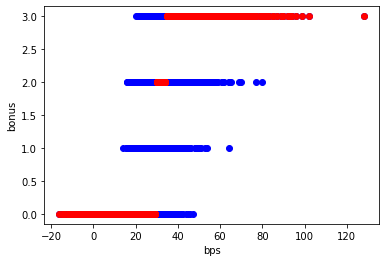

In [63]:
plt.scatter(all_data['bps'], all_data['bonus'], c='blue')
plt.scatter(X, y_pred, c='red')
plt.xlabel('bps')
plt.ylabel('bonus')
plt.show()

In [64]:
y_pred_prob = clf.predict_proba(X)
y_pred_prob

array([[9.99877921e-01, 1.17746525e-04, 4.13133327e-06, 2.00973920e-07],
       [8.94065597e-01, 7.10629628e-02, 2.68367569e-02, 8.03468363e-03],
       [9.87873606e-01, 1.00350777e-02, 1.78949390e-03, 3.01822286e-04],
       ...,
       [9.97120144e-01, 2.56998428e-03, 2.77899942e-04, 3.19716042e-05],
       [9.99877921e-01, 1.17746525e-04, 4.13133327e-06, 2.00973920e-07],
       [9.99755119e-01, 2.33729186e-04, 1.05312719e-05, 6.20301530e-07]])

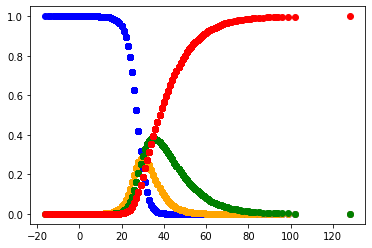

In [65]:
plt.scatter(X,y_pred_prob[:,0],c='blue')
plt.scatter(X,y_pred_prob[:,1],c='orange')
plt.scatter(X,y_pred_prob[:,2],c='green')
plt.scatter(X,y_pred_prob[:,3],c='red')

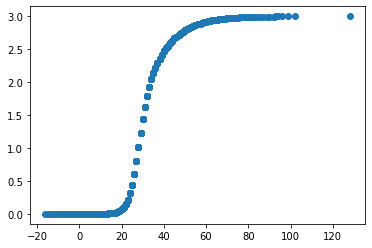

In [66]:
expected_bonus_points = np.matmul(y_pred_prob, np.array([0,1,2,3]).reshape((4,1)))
plt.scatter(X,expected_bonus_points)

In [67]:
# save model 

#model_path = f"../../models/logistic_regression_for_bonus_points.pkl"
#with open(model_path, "wb") as f:
    # save the model
#    pickle.dump(clf, f)

In [68]:
ix=21
clean_sheet_points = np.array([4,4,1,0])
goal_points = np.array([6,6,5,4])

# calculate expexted points
points_played = np.array([1 if all_data.loc[ix,'minutes']>0 else 0])
points_played_over_60 = np.array([1 if all_data.loc[ix,'minutes']>=60 else 0])
points_xG = np.matmul(all_data.loc[ix,fpl_positions_ordered].values, goal_points) * all_data.loc[ix,'Expected_xG']
points_xA = all_data.loc[ix,'Expected_xA'] * 3
clean_sheet_probability = np.array(poisson.pmf(0,all_data.loc[ix,'team_xGA']))
points_clean_sheet = [np.matmul(all_data.loc[ix,fpl_positions_ordered].values, clean_sheet_points)\
                        * clean_sheet_probability if all_data.loc[ix,'minutes']>=60 else 0]
#points_saves = np.matmul(all_data.loc[ix,fpl_positions_ordered].values, save_points) * (all_data.loc[ix,'saves'] // 3)
points_saves = all_data.loc[ix,'saves'] // 3
points_penalty_saves = all_data.loc[ix,'penalties_saved'] * 5 * 0.21 #points for save times approx. probability of penalty save
penalty_for_potential_penalty_miss = all_data.loc[ix,'Performance_PKatt'] * (-2*0.21)
# estimate bonus points
y_pred_prob = clf.predict_proba(all_data.loc[ix, 'bps'].reshape(-1, 1))
points_bonus = np.matmul(y_pred_prob, np.array([0,1,2,3]).reshape((4,1)))

# penalty for possible points deductions based on goals conceded
xGA = all_data.loc[ix,'team_xGA']
# calculate penalty
xGA_conceded_penalty = -(poisson.pmf(2,xGA)+poisson.pmf(3,xGA))-(poisson.pmf(4,xGA)+poisson.pmf(5,xGA))-(poisson.pmf(6,xGA)+poisson.pmf(7,xGA))-(poisson.pmf(8,xGA)+poisson.pmf(9,xGA)-(poisson.pmf(10,xGA)+poisson.pmf(11,xGA)))
# apply penalty only to GK and DEF
xGA_conceded_penalty = np.matmul(all_data.loc[ix,fpl_positions_ordered].values, np.array([1,1,0,0])) * xGA_conceded_penalty
# scale penalty with playing time
xGA_conceded_penalty = (all_data.loc[ix,'minutes'] / 90) * xGA_conceded_penalty

penalty_for_cards = [-3 if all_data.loc[ix,'red_cards']==1 else -1 if all_data.loc[ix,'yellow_cards']==1 else 0]
penalty_for_own_goal = -2 * all_data.loc[ix,'own_goals']

# add up all point components
total_points = points_played + points_played_over_60 + points_xG + points_xA + points_clean_sheet + points_saves +\
                points_penalty_saves + penalty_for_potential_penalty_miss + points_bonus + xGA_conceded_penalty +\
                penalty_for_cards + penalty_for_own_goal

print(f'Points for playing: {points_played}')
print(f'Points for playing over 60 minutes: {points_played_over_60}')
print(f'Points for xG: {points_xG}')
print(f'Points for xA: {points_xA}')
print(f'Clean_sheet_xPoints: {points_clean_sheet}')
print(f'Points for saves: {points_saves}')
print(f'Points for penalty saves: {points_penalty_saves}')
print(f'Penalty for potential penalty miss: {penalty_for_potential_penalty_miss}')
print(f'Bonus points: {points_bonus}')
print(f'xGA conceded penalty: {xGA_conceded_penalty}')
print(f'Penalty for cards: {penalty_for_cards}')
print(f'Penalty for own goals: {penalty_for_own_goal}')
print(f'Total xPoints: {total_points}')

Points for playing: [1]
Points for playing over 60 minutes: [1]
Points for xG: 0.0
Points for xA: 0.0
Clean_sheet_xPoints: [2.6812801841425573]
Points for saves: 0
Points for penalty saves: 0.0
Penalty for potential penalty miss: -0.0
Bonus points: [[0.4399205]]
xGA conceded penalty: -0.06155193550993302
Penalty for cards: [0]
Penalty for own goals: 0
Total xPoints: [[5.05964874]]


In [69]:
def calculate_xPoints(x,fpl_positions_ordered,clf):
    
    clean_sheet_points = np.array([4,4,1,0])
    goal_points = np.array([6,6,5,4])

    # calculate expexted points
    points_played = np.array([1 if x['minutes']>0 else 0])
    points_played_over_60 = np.array([1 if x['minutes']>=60 else 0])
    points_xG = np.matmul(x[fpl_positions_ordered].values, goal_points) * x['Expected_xG']
    points_xA = x['Expected_xA'] * 3
    clean_sheet_probability = np.array(poisson.pmf(0,x['team_xGA']))
    points_clean_sheet = [np.matmul(x[fpl_positions_ordered].values, clean_sheet_points) *\
                          clean_sheet_probability if x['minutes']>=60 else 0]
    points_saves = x['saves'] // 3
    points_penalty_saves = x['penalties_saved'] * 5 * 0.21 #points for save times approx. probability of penalty save
    penalty_for_potential_penalty_miss = x['Performance_PKatt'] * (-2*0.21)
    # estimate bonus points
    y_pred_prob = clf.predict_proba(np.array(x['bps']).reshape(-1, 1))
    points_bonus = np.matmul(y_pred_prob, np.array([0,1,2,3]).reshape((4,1)))

    # penalty for possible points deductions based on goals conceded
    xGA = x['team_xGA']
    # calculate penalty
    xGA_conceded_penalty = -(poisson.pmf(2,xGA)+poisson.pmf(3,xGA))-(poisson.pmf(4,xGA)+poisson.pmf(5,xGA))-(poisson.pmf(6,xGA)+poisson.pmf(7,xGA))-(poisson.pmf(8,xGA)+poisson.pmf(9,xGA)-(poisson.pmf(10,xGA)+poisson.pmf(11,xGA)))
    # apply penalty only to GK and DEF
    xGA_conceded_penalty = np.matmul(x[fpl_positions_ordered].values, np.array([1,1,0,0])) * xGA_conceded_penalty
    # scale penalty with playing time
    xGA_conceded_penalty = (x['minutes'] / 90) * xGA_conceded_penalty

    penalty_for_cards = [-3 if x['red_cards']==1 else -1 if x['yellow_cards']==1 else 0]
    penalty_for_own_goal = -2 * x['own_goals']

    # add up all point components
    total_points = float(points_played + points_played_over_60 + points_xG + points_xA + points_clean_sheet + points_saves +\
                    points_penalty_saves + penalty_for_potential_penalty_miss + points_bonus + xGA_conceded_penalty +\
                    penalty_for_cards + penalty_for_own_goal)
    
    return total_points

In [70]:
all_data['xPoints'] = all_data.apply(lambda x: calculate_xPoints(x,fpl_positions_ordered,clf), axis=1)
all_data['xPoints']

0        0.938102
1        3.381712
2        3.014520
3        8.066695
4        5.890018
           ...   
41112    1.589526
41113    1.736843
41114    2.371101
41115    0.995591
41116    2.100515
Name: xPoints, Length: 41117, dtype: float64

### Change player values to correct units

In [71]:
# change player values to correct units
all_data['value'] = all_data['value']/10.0
all_data['value']

0         5.0
1         5.5
2         7.0
3         5.0
4        10.5
         ... 
41112     4.3
41113     4.5
41114     4.9
41115     4.9
41116     5.9
Name: value, Length: 41117, dtype: float64

## Exponentially weighted variables

In [72]:
ewa_intervals = [5,10,20,40]
games_in_the_past = [5,10,20,40]

columns_for_difference = ['selected', 'transfers_balance', 'value']

columns_for_ewa = ['total_points', 'xPoints', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 
                   'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'minutes', 'own_goals', 'penalties_missed',
                   'penalties_saved', 'saves', 'threat', 'yellow_cards', 
                'Performance_Sh', 'Performance_SoT', 'Performance_Touches', 'Performance_Press', 'Performance_Tkl',
                  'Performance_Int', 'Performance_Blocks', 'Expected_xG', 'Expected_npxG', 'Expected_xA',
                  'SCA_SCA', 'Passes_Cmp', 'Passes_Cmp%', 'Passes_Prog', 'Carries_Carries', 'Carries_Prog',
                  'Dribbles_Succ', 'Dribbles_Att', 'General_KP', 'Touches_Att 3rd', 'Touches_Att Pen', 
                   'Performance_Recov', 'Aerial Duels_Won', 'Aerial Duels_Won%']
    
player_names = all_data['name'].unique()
new_all_data = pd.DataFrame()

for player_name in player_names:
    # find all entries for given player
    data = all_data[(all_data['name']==player_name)].sort_values(by='kickoff_time').copy()

    # info on number of games played recently
    for i in games_in_the_past:
        aux_list = []
        for ix in data.index:
            game_time = data.loc[ix, 'kickoff_time'] 
            aux_list.append(data[(data['kickoff_time']>=game_time-dt.timedelta(days=i)) &\
                                                           (data['kickoff_time']<game_time)].shape[0])
        data[f'games_in_past_{i}_days'] = aux_list        
        data[f'games_in_past_{i}_days_shifted_{j}'] = data[f'games_in_past_{i}_days'].shift(j)
        data = data.drop([f'games_in_past_{i}_days'],axis=1)
        
    # change in fpl ownership and value
    # shift values down (info known from previous game weeks before a new game)
    for col in columns_for_difference:
        data[f'{col}_shifted_{j}'] = data[col].shift(j)
    # change in fpl ownership 
    data[f'transfers_balance_%_shifted_{j}'] = data['transfers_balance'].shift(j) / data['selected'].shift(j)
    data[f'transfers_balance_%_ewa5_shifted_{j}'] = data[f'transfers_balance_%_shifted_{j}'].ewm(alpha=1/5).mean()
    data[f'transfers_balance_%_ewa10_shifted_{j}'] = data[f'transfers_balance_%_shifted_{j}'].ewm(alpha=1/10).mean()
    # change in fpl value
    for i in [1,2,5]:
        data[f'value_change_{i}_shifted_{j}'] = data['value'].diff(i).shift(j)
    
    # drop rows for games where the player did not play so these are not included when counting exponentially 
    # weighted averages
    data = data[data['minutes']>0]
    # calculate exponential weighted average for a number of statistics and shift down 1 row 
    # (so that this is the info known when trying to predict total_points of the row)
    data[f'goal_to_xg_ratio_ewa_40_shifted{j}'] = (data['goals_scored'] / data['Expected_xG']).ewm(alpha=1/40).mean().shift(j)
    for i in ewa_intervals:
        new_data = data[columns_for_ewa].ewm(alpha=1/i).mean().shift(j)
        new_columns = [col+f'_ewa_{i}_shifted_{j}' for col in columns_for_ewa]
        new_data.columns = new_columns
        data = pd.concat([data, new_data], axis=1)

    # add given player's data to the dataframe for all players
    new_all_data = pd.concat([new_all_data,data], axis=0)

display(new_all_data)

season                  name position  assists  bonus  bps  \
0      2017-18       Aaron Cresswell      DEF        0      0    3   
1752   2017-18       Aaron Cresswell      DEF        0      0   16   
3513   2017-18       Aaron Cresswell      DEF        0      0   11   
5141   2017-18       Aaron Cresswell      DEF        0      0   23   
5295   2017-18       Aaron Cresswell      DEF        0      3   30   
...        ...                   ...      ...      ...    ...  ...   
40554  2021-22        Tony Springett      MID        0      0    2   
40555  2021-22        Tony Springett      MID        0      0    9   
40921  2021-22        Tony Springett      MID        0      0    0   
40851  2021-22  Nathan Young-Coombes      FWD        0      0    2   
40970  2021-22           Isaac Price      MID        0      0   -2   

       clean_sheets  creativity  element  fixture  goals_conceded  \
0                 0         0.6      443        9               2   
1752              0        52.9      443       15               3   
3513              0         1.6      443       26               3   
5141              1        47.1      443       40               0   
5295              1        34.3      443       48               0   
...             ...         ...      ...      ...             ...   
40554             0         0.7      716      360               1   
40555             0        21.0      716      207               2   
40921             0         0.0      716      380               3   
40851             0         0.0      640      352               0   
40970             0         0.0      718      371               1   

       goals_scored  ict_index  influence              kickoff_time  minutes  \
0                 0        1.9        0.4 2017-08-13 15:00:00+00:00        9   
1752              0        7.4       21.2 2017-08-19 14:00:00+00:00       90   
3513              0        2.4       11.2 2017-08-26 14:00:00+00:00       90   
5141              0        6.2       14.2 2017-09-11 19:00:00+00:00       90   
5295              0        4.6       11.2 2017-09-16 14:00:00+00:00       90   
...             ...        ...        ...                       ...      ...   
40554             0        1.0        1.4 2022-05-08 13:00:00+00:00       45   
40555             0        5.3       13.0 2022-05-11 18:45:00+00:00       66   
40921             0        0.0        0.0 2022-05-22 15:00:00+00:00       29   
40851             0        0.0        0.0 2022-05-07 14:00:00+00:00        3   
40970             0        0.0        0.0 2022-05-22 15:00:00+00:00       13   

       opponent_team   opp_team_name  own_goals  penalties_missed  \
0                 12  Manchester Utd          0                 0   
1752              14     Southampton          0                 0   
3513              13   Newcastle Utd          0                 0   
5141               8    Huddersfield          0                 0   
5295              19       West Brom          0                 0   
...              ...             ...        ...               ...   
40554             19        West Ham          0                 0   
40555              9  Leicester City          0                 0   
40921             17       Tottenham          0                 0   
40851             16     Southampton          0                 0   
40970              1         Arsenal          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
0                    0          0      1      0     25136           0.0   
1752                 0          0      2      0     27824           2.0   
3513                 0          0      3      0     28464           0.0   
5141                 0          0      4      0     28977           0.0   
5295                 0          0      5      0     30355           0.0   
...                ...        ...    ...    ...       ...           ...   
40554                0 

In [73]:
len(set(all_data.index).difference(set(new_all_data.index)))

106

In [74]:
set(all_data.index).difference(set(new_all_data.index))

{92,
 101,
 598,
 755,
 778,
 1367,
 1407,
 1414,
 1422,
 1581,
 1585,
 1688,
 1716,
 1904,
 1976,
 2120,
 2202,
 2676,
 2703,
 2779,
 2848,
 3336,
 3879,
 4974,
 5026,
 5049,
 6091,
 6092,
 6175,
 6365,
 6462,
 6653,
 6742,
 6842,
 7029,
 7220,
 7221,
 7413,
 7414,
 7505,
 7686,
 8047,
 8330,
 8699,
 10981,
 13353,
 13498,
 13649,
 13823,
 14116,
 14423,
 14655,
 14898,
 15124,
 15340,
 15664,
 15726,
 15819,
 15823,
 15903,
 15968,
 16192,
 16288,
 16429,
 16597,
 16854,
 16922,
 17032,
 17444,
 17459,
 17698,
 17846,
 17850,
 17913,
 18331,
 18375,
 18581,
 19659,
 19668,
 19672,
 19676,
 19680,
 19687,
 19696,
 19705,
 19710,
 19721,
 19731,
 19736,
 19745,
 19759,
 19771,
 19775,
 19790,
 19808,
 19814,
 19820,
 19830,
 19834,
 19850,
 19860,
 19896,
 19899,
 19919,
 31298,
 39053}

In [75]:
all_data.loc[92:92]

season          name position  assists  bonus  bps  clean_sheets  \
92  2017-18  Kieran Gibbs      DEF        0      0    0             0   

    creativity  element  fixture  goals_conceded  goals_scored  ict_index  \
92         0.0        8        1               0             0        0.0   

    influence              kickoff_time  minutes  opponent_team  \
92        0.0 2017-08-11 18:45:00+00:00        0              9   

     opp_team_name  own_goals  penalties_missed  penalties_saved  red_cards  \
92  Leicester City          0                 0                0          0   

    round  saves  selected  team_a_score  team_h_score  threat  total_points  \
92      1      0      6359           3.0           4.0     0.0             0   

    transfers_balance  transfers_in  transfers_out  value  was_home  \
92                  0             0              0    5.0         1   

    yellow_cards  GW  General_# General_Nation General_Pos General_Age  \
92             0   1        3.0        eng ENG          LB      28-165   

    General_Min  Performance_Gls  Performance_Ast  Performance_PK  \
92         90.0                0                0               0   

    Performance_PKatt  Performance_Sh  Performance_SoT  Performance_CrdY  \
92                  0               0                0                 0   

    Performance_CrdR  Performance_Touches  Performance_Press  Performance_Tkl  \
92                 0                 48.0                3.0              1.0   

    Performance_Int  Performance_Blocks  Expected_xG  Expected_npxG  \
92                0                 0.0          0.0            0.0   

    Expected_xA  SCA_SCA  SCA_GCA  Passes_Cmp  Passes_Att  Passes_Cmp%  \
92          0.0      0.0      0.0        28.0        42.0         66.7   

    Passes_Prog  Carries_Carries  Carries_Prog  Dribbles_Succ  Dribbles_Att  \
92          4.0             22.0           6.0            0.0           0.0   

         team  Total_Cmp  Total_Att  Total_Cmp%  Total_TotDist  Total_PrgDist  \
92  West Brom       28.0       42.0        66.7          558.0          309.0   

    Short_Cmp  Short_Att  Short_Cmp%  Medium_Cmp  Medium_Att  Medium_Cmp%  \
92       10.0       10.0       100.0        13.0        23.0         56.5   

    Long_Cmp  Long_Att  Long_Cmp%  General_Ast  General_xA  General_KP  \
92       4.0       8.0       50.0            0         0.0         0.0   

    General_1/3  General_PPA  General_CrsPA  General_Prog  General_Att  \
92          5.0          0.0            0.0           4.0         42.0   

    Pass Types_Live  Pass Types_Dead  Pass Types_FK  Pass Types_TB  \
92             33.0              9.0            0.0            0.0   

    Pass Types_Press  Pass Types_Sw  Pass Types_Crs  Pass Types_CK  \
92               2.0            0.0               2            0.0   

    Corner Kicks_In  Corner Kicks_Out  Corner Kicks_Str  Height_Ground  \
92              0.0               0.0               0.0           15.0   

    Height_Low  Height_High  Body Parts_Left  Body Parts_Right  \
92         5.0         22.0             25.0               4.0   

    Body Parts_Head  Body Parts_TI  Body Parts_Other  Outcomes_Cmp  \
92              3.0            9.0               0.0          28.0   

    Outcomes_Off  Outcomes_Out  Outcomes_Int  Outcomes_Blocks  Tackles_Tkl  \
92           1.0           1.0           3.0              0.0          1.0   

    Tackles_TklW  Tackles_Def 3rd  Tackles_Mid 3rd  Tackles_Att 3rd  \
92             1              1.0              0.0              0.0   

    Vs Dribbles_Tkl  Vs Dribbles_Att  Vs Dribbles_Tkl%  Vs Dribbles_Past  \
92              0.0              1.0               0.0               1.0   

    Pressures_Press  Pressures_Succ  Pressures_%  Pressures_Def 3rd  \
92              3.0             0.0          0.0                2.0   

    Pressures_Mid 3rd  Pressures_Att 3rd  Blocks_Blocks  Blocks_Sh  \
92                1.0                0.0            0.0        

Seems like there's some issues with the fpl data missing but only a little and we can drop these data...

In [76]:
all_data_backup = all_data.copy()
all_data = new_all_data.copy()

In [77]:
all_data

season                  name position  assists  bonus  bps  \
0      2017-18       Aaron Cresswell      DEF        0      0    3   
1752   2017-18       Aaron Cresswell      DEF        0      0   16   
3513   2017-18       Aaron Cresswell      DEF        0      0   11   
5141   2017-18       Aaron Cresswell      DEF        0      0   23   
5295   2017-18       Aaron Cresswell      DEF        0      3   30   
...        ...                   ...      ...      ...    ...  ...   
40554  2021-22        Tony Springett      MID        0      0    2   
40555  2021-22        Tony Springett      MID        0      0    9   
40921  2021-22        Tony Springett      MID        0      0    0   
40851  2021-22  Nathan Young-Coombes      FWD        0      0    2   
40970  2021-22           Isaac Price      MID        0      0   -2   

       clean_sheets  creativity  element  fixture  goals_conceded  \
0                 0         0.6      443        9               2   
1752              0        52.9      443       15               3   
3513              0         1.6      443       26               3   
5141              1        47.1      443       40               0   
5295              1        34.3      443       48               0   
...             ...         ...      ...      ...             ...   
40554             0         0.7      716      360               1   
40555             0        21.0      716      207               2   
40921             0         0.0      716      380               3   
40851             0         0.0      640      352               0   
40970             0         0.0      718      371               1   

       goals_scored  ict_index  influence              kickoff_time  minutes  \
0                 0        1.9        0.4 2017-08-13 15:00:00+00:00        9   
1752              0        7.4       21.2 2017-08-19 14:00:00+00:00       90   
3513              0        2.4       11.2 2017-08-26 14:00:00+00:00       90   
5141              0        6.2       14.2 2017-09-11 19:00:00+00:00       90   
5295              0        4.6       11.2 2017-09-16 14:00:00+00:00       90   
...             ...        ...        ...                       ...      ...   
40554             0        1.0        1.4 2022-05-08 13:00:00+00:00       45   
40555             0        5.3       13.0 2022-05-11 18:45:00+00:00       66   
40921             0        0.0        0.0 2022-05-22 15:00:00+00:00       29   
40851             0        0.0        0.0 2022-05-07 14:00:00+00:00        3   
40970             0        0.0        0.0 2022-05-22 15:00:00+00:00       13   

       opponent_team   opp_team_name  own_goals  penalties_missed  \
0                 12  Manchester Utd          0                 0   
1752              14     Southampton          0                 0   
3513              13   Newcastle Utd          0                 0   
5141               8    Huddersfield          0                 0   
5295              19       West Brom          0                 0   
...              ...             ...        ...               ...   
40554             19        West Ham          0                 0   
40555              9  Leicester City          0                 0   
40921             17       Tottenham          0                 0   
40851             16     Southampton          0                 0   
40970              1         Arsenal          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
0                    0          0      1      0     25136           0.0   
1752                 0          0      2      0     27824           2.0   
3513                 0          0      3      0     28464           0.0   
5141                 0          0      4      0     28977           0.0   
5295                 0          0      5      0     30355           0.0   
...                ...        ...    ...    ...       ...           ...   
40554                0 

Let's calculate ewa for fbref position data

In [78]:
# calculate weighted averages of fbref positions for each player and add to all_data
new_column_data = pd.DataFrame()
new_columns_5 = [f'{col}_ewa5_shifted_{j}' for col in fbref_position_columns_ordered]
new_columns_10 = [f'{col}_ewa10_shifted_{j}' for col in fbref_position_columns_ordered]
new_columns_20 = [f'{col}_ewa20_shifted_{j}' for col in fbref_position_columns_ordered]
new_columns_40 = [f'{col}_ewa40_shifted_{j}' for col in fbref_position_columns_ordered]
for player_name in player_names:
    aux = all_data[(all_data['name']==player_name)].copy()
    aux[new_columns_5] = aux[fbref_position_columns_ordered].ewm(alpha=1/5).mean().shift(j)
    aux[new_columns_10] = aux[fbref_position_columns_ordered].ewm(alpha=1/10).mean().shift(j)
    aux[new_columns_20] = aux[fbref_position_columns_ordered].ewm(alpha=1/20).mean().shift(j)
    aux[new_columns_40] = aux[fbref_position_columns_ordered].ewm(alpha=1/40).mean().shift(j)
    aux = pd.concat([aux[new_columns_5],aux[new_columns_10],aux[new_columns_20],aux[new_columns_40]], axis=1)
    new_column_data = pd.concat([new_column_data, aux], axis=0)

# add data to all_data
all_data = pd.concat([all_data,new_column_data], axis=1)
display(all_data)

season                  name position  assists  bonus  bps  \
0      2017-18       Aaron Cresswell      DEF        0      0    3   
1752   2017-18       Aaron Cresswell      DEF        0      0   16   
3513   2017-18       Aaron Cresswell      DEF        0      0   11   
5141   2017-18       Aaron Cresswell      DEF        0      0   23   
5295   2017-18       Aaron Cresswell      DEF        0      3   30   
...        ...                   ...      ...      ...    ...  ...   
40554  2021-22        Tony Springett      MID        0      0    2   
40555  2021-22        Tony Springett      MID        0      0    9   
40921  2021-22        Tony Springett      MID        0      0    0   
40851  2021-22  Nathan Young-Coombes      FWD        0      0    2   
40970  2021-22           Isaac Price      MID        0      0   -2   

       clean_sheets  creativity  element  fixture  goals_conceded  \
0                 0         0.6      443        9               2   
1752              0        52.9      443       15               3   
3513              0         1.6      443       26               3   
5141              1        47.1      443       40               0   
5295              1        34.3      443       48               0   
...             ...         ...      ...      ...             ...   
40554             0         0.7      716      360               1   
40555             0        21.0      716      207               2   
40921             0         0.0      716      380               3   
40851             0         0.0      640      352               0   
40970             0         0.0      718      371               1   

       goals_scored  ict_index  influence              kickoff_time  minutes  \
0                 0        1.9        0.4 2017-08-13 15:00:00+00:00        9   
1752              0        7.4       21.2 2017-08-19 14:00:00+00:00       90   
3513              0        2.4       11.2 2017-08-26 14:00:00+00:00       90   
5141              0        6.2       14.2 2017-09-11 19:00:00+00:00       90   
5295              0        4.6       11.2 2017-09-16 14:00:00+00:00       90   
...             ...        ...        ...                       ...      ...   
40554             0        1.0        1.4 2022-05-08 13:00:00+00:00       45   
40555             0        5.3       13.0 2022-05-11 18:45:00+00:00       66   
40921             0        0.0        0.0 2022-05-22 15:00:00+00:00       29   
40851             0        0.0        0.0 2022-05-07 14:00:00+00:00        3   
40970             0        0.0        0.0 2022-05-22 15:00:00+00:00       13   

       opponent_team   opp_team_name  own_goals  penalties_missed  \
0                 12  Manchester Utd          0                 0   
1752              14     Southampton          0                 0   
3513              13   Newcastle Utd          0                 0   
5141               8    Huddersfield          0                 0   
5295              19       West Brom          0                 0   
...              ...             ...        ...               ...   
40554             19        West Ham          0                 0   
40555              9  Leicester City          0                 0   
40921             17       Tottenham          0                 0   
40851             16     Southampton          0                 0   
40970              1         Arsenal          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
0                    0          0      1      0     25136           0.0   
1752                 0          0      2      0     27824           2.0   
3513                 0          0      3      0     28464           0.0   
5141                 0          0      4      0     28977           0.0   
5295                 0          0      5      0     30355           0.0   
...                ...        ...    ...    ...       ...           ...   
40554                0 

## Add one-hot-encoded variables tagging special/important players

In [79]:
vip_players = []
player_names = all_data['name'].unique()
for player_name in player_names:
    aux = all_data[(all_data['name']==player_name)].copy()
    #if (aux['total_points'].mean()>5) & (aux.shape[0]>=20):
    if (aux['total_points'].mean() - (aux['xPoints'].mean()) >= 0.4) & \
        (aux['xPoints'].mean()>4) & (aux.shape[0]>=20):
        vip_players.append(player_name)
display(vip_players)

['Harry Kane',
 'Heung-Min Son',
 'Jamie Vardy',
 'Kevin De Bruyne',
 'Mohamed Salah',
 'Riyad Mahrez',
 'Sergio Aguero',
 'Bruno Miguel Borges Fernandes']

In [80]:
vip_players = [
    'Harry Kane',
    'Heung-Min Son',
    'Jamie Vardy',
    'Kevin De Bruyne',
    'Mohamed Salah',
    'Riyad Mahrez',
    'Bruno Miguel Borges Fernandes'
]

vip_columns = [
    'is_harry_kane',
    'is_heung_min_son',
    'is_jamie_vardy',
    'is_kevin_de_bruyne',
    'is_mohamed_salah',
    'is_riyad_mahrez',
    'is_bruno_fernandes'
]

In [81]:
display(len(vip_players))
display(len(vip_columns))

7

7

In [82]:
for i in range(0,7):
    # initialize with zeros
    all_data[vip_columns[i]] = 0
    # fill 1 for the correct player
    all_data.loc[all_data['name']==vip_players[i], vip_columns[i]] = 1

In [83]:
all_data

season                  name position  assists  bonus  bps  \
0      2017-18       Aaron Cresswell      DEF        0      0    3   
1752   2017-18       Aaron Cresswell      DEF        0      0   16   
3513   2017-18       Aaron Cresswell      DEF        0      0   11   
5141   2017-18       Aaron Cresswell      DEF        0      0   23   
5295   2017-18       Aaron Cresswell      DEF        0      3   30   
...        ...                   ...      ...      ...    ...  ...   
40554  2021-22        Tony Springett      MID        0      0    2   
40555  2021-22        Tony Springett      MID        0      0    9   
40921  2021-22        Tony Springett      MID        0      0    0   
40851  2021-22  Nathan Young-Coombes      FWD        0      0    2   
40970  2021-22           Isaac Price      MID        0      0   -2   

       clean_sheets  creativity  element  fixture  goals_conceded  \
0                 0         0.6      443        9               2   
1752              0        52.9      443       15               3   
3513              0         1.6      443       26               3   
5141              1        47.1      443       40               0   
5295              1        34.3      443       48               0   
...             ...         ...      ...      ...             ...   
40554             0         0.7      716      360               1   
40555             0        21.0      716      207               2   
40921             0         0.0      716      380               3   
40851             0         0.0      640      352               0   
40970             0         0.0      718      371               1   

       goals_scored  ict_index  influence              kickoff_time  minutes  \
0                 0        1.9        0.4 2017-08-13 15:00:00+00:00        9   
1752              0        7.4       21.2 2017-08-19 14:00:00+00:00       90   
3513              0        2.4       11.2 2017-08-26 14:00:00+00:00       90   
5141              0        6.2       14.2 2017-09-11 19:00:00+00:00       90   
5295              0        4.6       11.2 2017-09-16 14:00:00+00:00       90   
...             ...        ...        ...                       ...      ...   
40554             0        1.0        1.4 2022-05-08 13:00:00+00:00       45   
40555             0        5.3       13.0 2022-05-11 18:45:00+00:00       66   
40921             0        0.0        0.0 2022-05-22 15:00:00+00:00       29   
40851             0        0.0        0.0 2022-05-07 14:00:00+00:00        3   
40970             0        0.0        0.0 2022-05-22 15:00:00+00:00       13   

       opponent_team   opp_team_name  own_goals  penalties_missed  \
0                 12  Manchester Utd          0                 0   
1752              14     Southampton          0                 0   
3513              13   Newcastle Utd          0                 0   
5141               8    Huddersfield          0                 0   
5295              19       West Brom          0                 0   
...              ...             ...        ...               ...   
40554             19        West Ham          0                 0   
40555              9  Leicester City          0                 0   
40921             17       Tottenham          0                 0   
40851             16     Southampton          0                 0   
40970              1         Arsenal          0                 0   

       penalties_saved  red_cards  round  saves  selected  team_a_score  \
0                    0          0      1      0     25136           0.0   
1752                 0          0      2      0     27824           2.0   
3513                 0          0      3      0     28464           0.0   
5141                 0          0      4      0     28977           0.0   
5295                 0          0      5      0     30355           0.0   
...                ...        ...    ...    ...       ...           ...   
40554                0 

In [84]:
all_data[all_data['is_harry_kane']==1]

season        name position  assists  bonus  bps  clean_sheets  \
56     2017-18  Harry Kane      FWD        0      0   -6             1   
1803   2017-18  Harry Kane      FWD        0      0   -3             0   
3567   2017-18  Harry Kane      FWD        0      0    7             0   
5195   2017-18  Harry Kane      FWD        0      3   58             1   
5351   2017-18  Harry Kane      FWD        0      0    1             1   
5500   2017-18  Harry Kane      FWD        0      3   45             0   
5647   2017-18  Harry Kane      FWD        0      3   52             1   
5797   2017-18  Harry Kane      FWD        0      0    0             1   
5943   2017-18  Harry Kane      FWD        1      3   61             0   
378    2017-18  Harry Kane      FWD        0      0    6             1   
534    2017-18  Harry Kane      FWD        0      0    1             0   
693    2017-18  Harry Kane      FWD        0      2   25             0   
853    2017-18  Harry Kane      FWD        0      0   26             0   
1018   2017-18  Harry Kane      FWD        0      0    3             0   
1169   2017-18  Harry Kane      FWD        0      2   37             0   
1332   2017-18  Harry Kane      FWD        0      0   11             1   
1497   2017-18  Harry Kane      FWD        0      0   -2             0   
1654   2017-18  Harry Kane      FWD        0      3   81             1   
1968   2017-18  Harry Kane      FWD        0      3   71             0   
2280   2017-18  Harry Kane      FWD        0      0    3             0   
2281   2017-18  Harry Kane      FWD        0      0    1             0   
2455   2017-18  Harry Kane      FWD        0      3   53             1   
2610   2017-18  Harry Kane      FWD        0      2   23             0   
2773   2017-18  Harry Kane      FWD        0      0    1             1   
2924   2017-18  Harry Kane      FWD        0      0   17             0   
3086   2017-18  Harry Kane      FWD        0      0   21             1   
3246   2017-18  Harry Kane      FWD        0      0   23             1   
3405   2017-18  Harry Kane      FWD        1      0   12             1   
3725   2017-18  Harry Kane      FWD        0      0    2             0   
3947   2017-18  Harry Kane      FWD        0      0    3             0   
4113   2017-18  Harry Kane      FWD        0      0    2             0   
4297   2017-18  Harry Kane      FWD        0      0    4             0   
4298   2017-18  Harry Kane      FWD        0      2   32             0   
4601   2017-18  Harry Kane      FWD        0      0   27             1   
4816   2017-18  Harry Kane      FWD        0      0    3             0   
4817   2017-18  Harry Kane      FWD        0      0   27             1   
5041   2017-18  Harry Kane      FWD        0      2   53             0   
6109   2018-19  Harry Kane      FWD        0      0    5             0   
6294   2018-19  Harry Kane      FWD        0      1   24             0   
6480   2018-19  Harry Kane      FWD        1      2   35             1   
6672   2018-19  Harry Kane      FWD        0      0    1             0   
6863   2018-19  Harry Kane      FWD        0      0    2             0   
7048   2018-19  Harry Kane      FWD        0      3   35             0   
7240   2018-19  Harry Kane      FWD        0      3   59             1   
7435   2018-19  Harry Kane      FWD        0      0    5             1   
7621   2018-19  Harry Kane      FWD        0      0    3             1   
7803   2018-19  Harry Kane      FWD        0      0   -4             0   
7980   2018-19  Harry Kane      FWD        0      1   30             0   
8164   2018-19  Harry Kane      FWD        1      0    7             1   
8352   2018-19  Harry Kane      FWD        0      0   30             0   
8531   2018-19  Harry Kane      FWD        0      0   25             0   
8720   2018-19  Harry Kane      FWD        1      3   40             0   
8905   2018-19  Harry Kane      FWD        0      0    5             0   
9095   2018-

In [85]:
# change tackles to 0 for goalkeepers (very rare, but some have positive values and these seemed to be picked
# up heavily (and  contradictorily) by the modelling, which is undesirable)
#all_data.loc[(all_data['fpl_position_GK']==1), 'Performance_Tkl_ewa_5'] = 0
#all_data.loc[(all_data['fpl_position_GK']==1), 'Performance_Tkl_ewa_10'] = 0
#all_data.loc[(all_data['fpl_position_GK']==1), 'Performance_Tkl_ewa_20'] = 0
#all_data.loc[(all_data['fpl_position_GK']==1), 'Performance_Tkl_ewa_40'] = 0

In [86]:
np.array(all_data.columns)

array(['season', 'name', 'position', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture',
       'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       'kickoff_time', 'minutes', 'opponent_team', 'opp_team_name',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'round', 'saves', 'selected', 'team_a_score', 'team_h_score',
       'threat', 'total_points', 'transfers_balance', 'transfers_in',
       'transfers_out', 'value', 'was_home', 'yellow_cards', 'GW',
       'General_#', 'General_Nation', 'General_Pos', 'General_Age',
       'General_Min', 'Performance_Gls', 'Performance_Ast',
       'Performance_PK', 'Performance_PKatt', 'Performance_Sh',
       'Performance_SoT', 'Performance_CrdY', 'Performance_CrdR',
       'Performance_Touches', 'Performance_Press', 'Performance_Tkl',
       'Performance_Int', 'Performance_Blocks', 'Expected_xG',
       'Expected_npxG', 'Expected_xA', 'SCA_SCA', 'SCA_GCA', 'Passes_Cmp'

In [87]:
all_data.to_csv(f'../../data/data_for_predicting.csv')